# **SHAP - SHapley Additive exPlanations**

#### Import packages and manipulation functions

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from itertools import repeat, chain
import copy
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import scipy
# from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm
import shap


style.use('seaborn-v0_8-ticks')
plt.rcParams.update({'figure.facecolor':'white'})
sns.set_theme(style="ticks")

import os
from pathlib import Path

# Store the original directory path in a global variable if it doesn't exist yet
if not hasattr(__builtins__, '_original_dir'):
    __builtins__._original_dir = os.getcwd()
    root_dir = Path(__builtins__._original_dir).resolve().parent
    os.chdir(root_dir)
    print(f"Changed working directory to: {os.getcwd()}")
else:
    print(f"Directory already changed. Current working directory: {os.getcwd()}")

from utils.data_preparation import preprocess_data, split_data, mapping
from processing.custom_metrics import nash_sutcliffe, kling_gupta

Changed working directory to: C:\Users\xkorpijo3\OneDrive - Fortum\Desktop\Master-thesis-GBRT-dam


In [3]:
color = '\033[1m\033[38;5;208m' 
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version SHAP: {shap.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
print(f"{color}Version seasborn: {sns.__version__}")

Version scikit-learn: 1.5.2
Version lightgbm: 4.5.0
Version SHAP: 0.46.0
Version pandas: 2.2.3
Version numpy: 1.26.4
Version seasborn: 0.13.2


In [4]:
def determine_unit(target):
    """Determine the unit based on the target variable."""
    return 'MASL' if 'GV' in target else 'L/s' if 'MB' in target else None

### **Define target of analysis**

In [5]:
target = 'GV51'

In [6]:
features = ['h', 'h_MA_060', 'h_MA_180',
            'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
            'P', 'P_RS_180',
            'Q', 'Q_RS_030', 'Q_RS_120',
            't', 'month']

# features = ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18',
#             'h', 'h_MA_060', 'h_MA_180',
#             'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
#             'P', 'P_RS_180',
#             'Q', 'Q_RS_030', 'Q_RS_120',
#             't', 'month']


all_features_grouped = {
    'Reservoir level': ['h', 'h_MA_060', 'h_MA_180',],
    'Air Temperature': ['TA', 'TA_MA_180'],
    'Lagged Air Temperature': ['TA_lag_060', 'TA_lag_090'],
    'Precipitation': ['P'],
    'Accumulated Precipitation': ['P_RS_180'],
    'Local Inflow': ['Q'],
    'Accumulated Local Inflow': ['Q_RS_090', 'Q_RS_120'],
    'Temporal features': ['t', 'month'],
    # 'GV1': ['GV1'], 
    # 'GV3': ['GV3'], 
    # 'GV51': ['GV51'],
    # 'MB4': ['MB4'], 
    # 'MB8': ['MB8'], 
    # 'MB10': ['MB10'],
    # 'MB18': ['MB18']
}

feature_categories = {
    'Response': ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18'],
    'Environmental': ['h', 'h_MA_060', 'h_MA_180',
                     'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
                     'P', 'P_RS_180',
                     'Q', 'Q_RS_030', 'Q_RS_120',
                     't', 'month']
}

features_derived = {
    'Original': ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18', 'h', 'TA', 'P', 'Q'],
    'Environmental': ['h_MA_060', 'h_MA_180',
                     'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
                     'P_RS_180',
                     'Q_RS_030', 'Q_RS_120',
                     't', 'month']
}

In [7]:
# Sanity check that all elements are included
print(len(features))

total_elements = sum(len(sublist) for sublist in list(all_features_grouped.values()))
print(total_elements)

total_elements = sum(len(sublist) for sublist in list(feature_categories.values()))
print(total_elements)

total_elements = sum(len(sublist) for sublist in list(features_derived.values()))
print(total_elements)

14
14
21
21


In [8]:
test_size = 0.2
poly_degree = 0

if target in features: features.remove(target)
if target in all_features_grouped: del all_features_grouped[target]
path = f'./data/LOS_DAMM_{mapping(target)}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])

# Extract start and end dates
dates = data['Date-Time']
start_date = dates.iloc[0].date()  # First date (YYYY-MM-DD)
end_date = dates.iloc[-1].date()  # Last date (YYYY-MM-DD)

# Preprocess the data (You would need to define preprocess_data elsewhere in your code)
X, y, dates = preprocess_data(features, target, start_date, end_date, poly_degree=poly_degree, test_size=test_size)

# Split the data into training and testing sets (Assumes split_data is defined elsewhere)
X_train, X_test, y_train, y_test, split_index = split_data(X, y, test_size=test_size)

# Concatenate training and test data for full data (if needed)
X_all = pd.concat([X_train, X_test])

print("data loaded")

with open(f'./visualization/models/LightGBM/LightGBM_model_{target}.pkl', 'rb') as f:
    LGBM_model = pickle.load(f)

print(f"{target} LGBM_model loaded")

data loaded
GV51 LGBM_model loaded


In [9]:
LGBM_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.8552996267089586,
              learning_rate=0.03286202028083, linear_tree=False, max_depth=6,
              min_split_gain=0.6280661793078444, n_estimators=2951,
              num_leaves=3, reg_alpha=2.5137862899800223,
              reg_lambda=3.9430716192876, subsample=0.49235297280952,
              verbose=-1)

#### Sanity check that model is correct and predicts well

In [10]:
print("Feature names:")
print(LGBM_model.feature_name_, '\n')

train_predictions = LGBM_model.predict(X_train)
test_predictions = LGBM_model.predict(X_test)
all_predictions = LGBM_model.predict(X_all)

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
mae_test = mean_absolute_error(y_test, test_predictions)
NSE_test = nash_sutcliffe(y_test, test_predictions)
KGE_test = kling_gupta(y_test, test_predictions)

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)
print("NSE Test:", NSE_test)
print("KGE Test:", KGE_test)

Feature names:
['t', 'month', 'h', 'h_MA_060', 'h_MA_180', 'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 'P', 'P_RS_180', 'Q', 'Q_RS_030', 'Q_RS_120'] 

RMSE Train: 0.15384411588778826
RMSE Test: 0.5383597627773131
MAE Test: 0.4368273770811632
NSE Test: 0.9838355342299463
KGE Test: 0.9471330536560743


## **VISUALIZING THE TARGET AND THE BACKGROUND DATA PASSED TO SHAP**

In [43]:
def create_yearly_comparison(X_all, dates, target_column):
    """
    Create a DataFrame with yearly data for seasonal comparison,
    and return dates for each year. Non-leap years will have NaN values for Feb 29.
    
    Parameters:
    -----------
    X_all : pandas.DataFrame
        DataFrame containing the features, including the target column
    dates : pandas.Series
        Series of datetime values, same length as X_all
    target_column : str
        Name of the column in X_all to analyze (e.g., 'X1')
        
    Returns:
    --------
    tuple
        (yearly_data, year_dates)
        - yearly_data: DataFrame with separate columns for each year,
          with indices representing the same point in time within each year
        - year_dates: Dictionary with years as keys and corresponding dates as values
    """
    import pandas as pd
    
    # Create a DataFrame that combines dates and target values
    df = pd.DataFrame({
        'datetime': dates,
        'target': X_all[target_column]
    })
    
    # Extract components needed for seasonal grouping
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    
    # Instead of using dayofyear, create a custom seasonal day that accounts for leap years
    # Create a standard date to align all years (using month, day, hour)
    # Use a leap year (2020) as reference for creating a standard date series
    df['ref_date'] = pd.to_datetime(
        '2020-' + df['month'].astype(str) + '-' + df['day'].astype(str) + ' ' + df['hour'].astype(str) + ':00:00'
    )
    
    # Extract the day of year from this reference date (all based on leap year)
    df['season_day'] = df['ref_date'].dt.dayofyear + df['hour']/24
    
    # Create a dictionary to store dates for each year
    year_dates = {}
    for year in df['year'].unique():
        year_dates[year] = df.loc[df['year'] == year, 'datetime'].values
    
    # Pivot the data to have separate columns for each year
    yearly_data = df.pivot_table(
        index=['season_day'],  # Use season_day for continuous representation
        columns='year',
        values='target',
        aggfunc='mean'  # In case there are duplicates
    ).reset_index()
    
    # Rename columns
    yearly_data.columns.name = None
    
    # Create proper time components from season_day
    # First, get the integer part (days)
    days = yearly_data['season_day'].astype(int)
    
    # Then, get the fractional part converted to hours (0-23)
    fractional_day = yearly_data['season_day'] - days
    hours = (fractional_day * 24).round().astype(int)
    
    # Handle edge case where hours == 24
    days = days + (hours == 24).astype(int)
    hours = hours % 24
    
    # Create a reference date (Jan 1 of a leap year) and add the days
    base_date = pd.to_datetime('2020-01-01') + pd.to_timedelta(days - 1, unit='D')
    
    yearly_data['month'] = base_date.dt.month
    yearly_data['day'] = base_date.dt.day
    yearly_data['week'] = base_date.dt.isocalendar().week
    yearly_data['hour'] = hours

    # Add quarter (1-4) based on month
    yearly_data['quarter'] = ((yearly_data['month'] - 1) // 3) + 1
    
    return yearly_data, year_dates

In [44]:
def plot_timeseries_with_highlight(dates, data, target_column, yearly_dates, 
                                   highlight_type='month', 
                                   periods_to_highlight=None, period_colors=None,
                                   figsize=(10, 6), alpha=0.2, line_color=None,
                                   ylabel='Value', title=None, grid=True,
                                   legend_loc='lower left'):
    """
    Plot a time series with highlighted months or quarters.
    
    Parameters:
    -----------
    dates : pandas.Series
        Series of datetime values
    data : pandas.DataFrame
        DataFrame containing the data to plot
    target_column : str
        Column name in data to plot
    yearly_dates : dict
        Dictionary with years as keys and datetime arrays as values
    highlight_type : str, optional
        'month' or 'quarter' to specify the type of period to highlight
    periods_to_highlight : int or list, optional
        If int: Single period to highlight
        If list: Multiple periods to highlight with colors from period_colors
        For months: 1-12
        For quarters: 1-4
    period_colors : list, optional
        List of colors to use for the periods. If None, default colors will be used.
    figsize : tuple, optional
        Figure size (width, height)
    alpha : float, optional
        Transparency of shaded regions
    line_color : str, optional
        Color of the main line plot
    ylabel : str, optional
        Y-axis label
    title : str, optional
        Plot title
    grid : bool, optional
        Whether to show grid
    legend_loc : str, optional
        Location of the legend
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib.patches as mpatches
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the main data
    line_kwargs = {'linewidth': 2}
    if line_color:
        line_kwargs['color'] = line_color
    
    line = ax.plot(dates, data[target_column], label=target_column, **line_kwargs)[0]
    
    # Define quarter to month mapping
    quarter_to_months = {
        1: [1, 2, 3],
        2: [4, 5, 6],
        3: [7, 8, 9],
        4: [10, 11, 12]
    }
    
    # Process periods_to_highlight parameter
    if periods_to_highlight is None:
        # No highlighting requested
        periods_list = []
    elif isinstance(periods_to_highlight, int):
        # Single period as integer
        periods_list = [periods_to_highlight]
        if period_colors is None:
            period_colors = ['gray']
    elif isinstance(periods_to_highlight, list):
        # List of periods
        periods_list = periods_to_highlight
        if period_colors is None:
            # Generate colors if not provided
            cmap = plt.cm.tab10
            period_colors = [cmap(i % 10) for i in range(len(periods_list))]
    else:
        raise ValueError("periods_to_highlight must be an int or list")
    
    # Make sure period_colors is at least as long as periods_list
    if len(period_colors) < len(periods_list):
        cmap = plt.cm.tab10
        period_colors.extend([cmap(i % 10) for i in range(len(period_colors), len(periods_list))])
    
    # Create patches for legend
    legend_patches = [line]
    legend_labels = [target_column]
    
    # Highlight periods
    if periods_to_highlight is not None:
        for i, period in enumerate(periods_list):
            color = period_colors[i]
            
            # Determine months to include based on highlight type
            if highlight_type.lower() == 'month':
                months_to_include = [period]
                period_label = f'Month {period:02d}'
            elif highlight_type.lower() == 'quarter':
                if period < 1 or period > 4:
                    raise ValueError("Quarter must be between 1 and 4")
                months_to_include = quarter_to_months[period]
                period_label = f'Q{period}'
            else:
                raise ValueError("highlight_type must be 'month' or 'quarter'")
            
            # Add to legend
            legend_patches.append(mpatches.Patch(color=color, alpha=alpha))
            legend_labels.append(period_label)
            
            # Process each year
            for year, year_dates_array in yearly_dates.items():
                # Convert to pandas datetime if needed
                if not isinstance(year_dates_array, pd.DatetimeIndex):
                    year_dates = pd.DatetimeIndex(year_dates_array)
                else:
                    year_dates = year_dates_array
                
                if highlight_type.lower() == 'month':
                    # For months, process each month individually
                    for month in months_to_include:
                        # Find all dates in this year that match the target month
                        month_dates = year_dates[year_dates.month == month]
                        
                        # Only create a span if we have dates for this month in this year
                        if len(month_dates) > 0:
                            # Get the first and last date for this month
                            start_date = month_dates[0]
                            end_date = month_dates[-1]
                            
                            # Create a single span for the whole month
                            ax.axvspan(start_date, end_date, alpha=alpha, color=color)
                
                elif highlight_type.lower() == 'quarter':
                    # For quarters, find the first month and last month to create one continuous span
                    quarter_dates = year_dates[year_dates.month.isin(months_to_include)]
                    
                    if len(quarter_dates) > 0:
                        # Get the first and last date for this quarter
                        start_date = quarter_dates[0]
                        end_date = quarter_dates[-1]
                        
                        # Create a single span for the whole quarter
                        ax.axvspan(start_date, end_date, alpha=alpha, color=color)
    
    # Set labels and style
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel(ylabel)
    
    if title:
        ax.set_title(title)
    
    # Add the legend with our custom handles and labels
    ax.legend(handles=legend_patches, labels=legend_labels, loc=legend_loc, fontsize=12)
    
    if grid:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

In [45]:
# yearly_h, yearly_dates = create_yearly_comparison(X_all, dates, 'h')

# # Plotting all water levels data
# plt.figure(figsize=(10, 6))

# # Plot your main data
# plt.plot(dates, X_all['h'], label='h')

# # Define the month you want to highlight
# month_to_highlight = 2  # February

# # Create one span per year using the yearly_dates dictionary
# for year, year_dates_array in yearly_dates.items():
#     # Convert to pandas datetime if needed
#     year_dates = pd.DatetimeIndex(year_dates_array)
    
#     # Find all dates in this year that match the target month
#     month_dates = year_dates[year_dates.month == month_to_highlight]
    
#     # Only create a span if we have dates for this month in this year
#     if len(month_dates) > 0:
#         # Get the first and last date for this month
#         start_date = month_dates[0]
#         end_date = month_dates[-1]
        
#         # Create a single span for the whole month
#         plt.axvspan(start_date, end_date, alpha=0.2, color='gray')

# plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
# plt.tick_params(axis='x', rotation=45)
# plt.ylabel('Reservoir level (MASL)')
# plt.legend(loc='lower left', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.show()

In [46]:
def plot_timeseries_with_highlight(dates, data, target_column=None, yearly_dates=None, 
                                   predictions=None, prediction_dates=None,
                                   highlight_type='month', 
                                   periods_to_highlight=None, period_colors=None,
                                   show_only_highlighted=False,
                                   figsize=(10, 6), alpha=0.2, line_color=None,
                                   pred_color='red', pred_linestyle='--',
                                   ylabel='Value', title=None, grid=True,
                                   legend_loc='lower left'):
    """
    Plot a time series with highlighted months or quarters and optional predictions.
    Works with both pandas DataFrame (specify target_column) and Series (leave target_column as None).
    
    Parameters:
    -----------
    dates : pandas.Series or array-like
        Series of datetime values for the main data
    data : pandas.DataFrame or pandas.Series
        DataFrame containing the data to plot, or a Series to plot directly
    target_column : str, optional
        Column name in data to plot if data is a DataFrame. 
        Leave as None if data is a Series.
    yearly_dates : dict, optional
        Dictionary with years as keys and datetime arrays as values for highlighting
        If None, no highlighting will be applied
    predictions : pandas.Series or array-like, optional
        Prediction values to plot as a second line
    prediction_dates : pandas.Series or array-like, optional
        Dates for predictions (if different from main dates). If None, uses same dates as main data.
    highlight_type : str, optional
        'month' or 'quarter' to specify the type of period to highlight
    periods_to_highlight : int or list, optional
        If int: Single period to highlight
        If list: Multiple periods to highlight with colors from period_colors
        For months: 1-12
        For quarters: 1-4
    period_colors : list, optional
        List of colors to use for the periods. If None, default colors will be used.
    show_only_highlighted : bool, optional
        If True, only shows data in the highlighted periods
    figsize : tuple, optional
        Figure size (width, height)
    alpha : float, optional
        Transparency of shaded regions
    line_color : str, optional
        Color of the main line plot
    pred_color : str, optional
        Color for the prediction line
    pred_linestyle : str, optional
        Line style for the prediction line
    ylabel : str, optional
        Y-axis label
    title : str, optional
        Plot title
    grid : bool, optional
        Whether to show grid
    legend_loc : str, optional
        Location of the legend
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib.patches as mpatches
    import numpy as np
    from matplotlib.dates import date2num
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine what to plot based on input type
    line_kwargs = {'linewidth': 2}
    if line_color:
        line_kwargs['color'] = line_color
    
    # Determine the label for the plot
    if isinstance(data, pd.Series):
        values_to_plot = data.copy()
        label = data.name if data.name is not None else "Actual"
    else:  # DataFrame
        if target_column is None:
            raise ValueError("target_column must be specified when data is a DataFrame")
        values_to_plot = data[target_column].copy()
        label = target_column
    
    # Convert dates to pandas DatetimeIndex if it's not already
    if not isinstance(dates, pd.DatetimeIndex):
        dates = pd.DatetimeIndex(dates)
    
    # Use main dates if prediction_dates not provided
    pred_dates = prediction_dates if prediction_dates is not None else dates
    
    # If we need to show only highlighted data
    if show_only_highlighted and yearly_dates is not None and periods_to_highlight is not None:
        # Create a mask that's initially all False
        highlight_mask = np.zeros(len(dates), dtype=bool)
        
        # Define quarter to month mapping
        quarter_to_months = {
            1: [1, 2, 3],
            2: [4, 5, 6],
            3: [7, 8, 9],
            4: [10, 11, 12]
        }
        
        # Convert periods_to_highlight to a list
        if isinstance(periods_to_highlight, int):
            periods_list = [periods_to_highlight]
        elif isinstance(periods_to_highlight, list):
            periods_list = periods_to_highlight
        else:
            raise ValueError("periods_to_highlight must be an int or list")
        
        # For each period and year, update the mask
        for period in periods_list:
            # Determine months to include based on highlight type
            if highlight_type.lower() == 'month':
                months_to_include = [period]
            elif highlight_type.lower() == 'quarter':
                months_to_include = quarter_to_months[period]
            else:
                raise ValueError("highlight_type must be 'month' or 'quarter'")
            
            # Update mask for each matching date
            for year_date in yearly_dates.values():
                year_dates = pd.DatetimeIndex(year_date)
                for month in months_to_include:
                    month_dates = year_dates[year_dates.month == month]
                    if len(month_dates) > 0:
                        start_date = month_dates[0]
                        end_date = month_dates[-1]
                        # Update mask for dates in this range
                        highlight_mask |= (dates >= start_date) & (dates <= end_date)
        
        # Apply mask to create masked data
        masked_values = values_to_plot.copy()
        masked_values[~highlight_mask] = np.nan
        
        # Prepare masked predictions if they exist
        if predictions is not None:
            # Convert prediction_dates to DatetimeIndex if it's not already
            if not isinstance(pred_dates, pd.DatetimeIndex):
                pred_dates = pd.DatetimeIndex(pred_dates)
            
            # Create mask for predictions
            pred_highlight_mask = np.zeros(len(pred_dates), dtype=bool)
            for period in periods_list:
                if highlight_type.lower() == 'month':
                    months_to_include = [period]
                elif highlight_type.lower() == 'quarter':
                    months_to_include = quarter_to_months[period]
                
                for year_date in yearly_dates.values():
                    year_dates = pd.DatetimeIndex(year_date)
                    for month in months_to_include:
                        month_dates = year_dates[year_dates.month == month]
                        if len(month_dates) > 0:
                            start_date = month_dates[0]
                            end_date = month_dates[-1]
                            pred_highlight_mask |= (pred_dates >= start_date) & (pred_dates <= end_date)
            
            # Apply mask to predictions
            masked_predictions = predictions.copy()
            masked_predictions[~pred_highlight_mask] = np.nan
            predictions_to_plot = masked_predictions
        else:
            predictions_to_plot = None
        
        # Use masked values
        values_to_plot = masked_values
    else:
        # Use original values
        predictions_to_plot = predictions
    
    # Plot the actual data
    main_line = ax.plot(dates, values_to_plot, label=label, **line_kwargs)[0]
    
    # Store all lines and labels for legend
    all_lines = [main_line]
    all_labels = [label]
    
    # Plot predictions if provided
    if predictions_to_plot is not None:
        pred_kwargs = {
            'color': pred_color,
            'linestyle': pred_linestyle,
            'linewidth': 2
        }
        
        # Make sure dates and predictions have the same length
        if len(pred_dates) != len(predictions_to_plot):
            raise ValueError("prediction_dates and predictions must have the same length")
        
        # Plot predictions
        pred_line = ax.plot(pred_dates, predictions_to_plot, label='Predicted', **pred_kwargs)[0]
        all_lines.append(pred_line)
        all_labels.append('Predicted')
    
    # Skip highlighting if yearly_dates is None
    if yearly_dates is not None:
        # Define quarter to month mapping if not already defined
        if not 'quarter_to_months' in locals():
            quarter_to_months = {
                1: [1, 2, 3],
                2: [4, 5, 6],
                3: [7, 8, 9],
                4: [10, 11, 12]
            }
        
        # Process periods_to_highlight parameter if not already processed
        if not 'periods_list' in locals():
            if periods_to_highlight is None:
                # No highlighting requested
                periods_list = []
            elif isinstance(periods_to_highlight, int):
                # Single period as integer
                periods_list = [periods_to_highlight]
                if period_colors is None:
                    period_colors = ['gray']
            elif isinstance(periods_to_highlight, list):
                # List of periods
                periods_list = periods_to_highlight
                if period_colors is None:
                    # Generate colors if not provided
                    cmap = plt.cm.tab10
                    period_colors = [cmap(i % 10) for i in range(len(periods_list))]
            else:
                raise ValueError("periods_to_highlight must be an int or list")
        
        # Make sure period_colors is at least as long as periods_list
        if period_colors is None:
            cmap = plt.cm.tab10
            period_colors = [cmap(i % 10) for i in range(len(periods_list))]
        elif len(period_colors) < len(periods_list):
            cmap = plt.cm.tab10
            period_colors.extend([cmap(i % 10) for i in range(len(period_colors), len(periods_list))])
        
        # Create patches for legend
        legend_patches = all_lines.copy()
        legend_labels = all_labels.copy()
        
        # Highlight periods
        if periods_to_highlight is not None:
            for i, period in enumerate(periods_list):
                color = period_colors[i]
                
                # Determine months to include based on highlight type
                if highlight_type.lower() == 'month':
                    months_to_include = [period]
                    period_label = f'Month {period:02d}'
                elif highlight_type.lower() == 'quarter':
                    if period < 1 or period > 4:
                        raise ValueError("Quarter must be between 1 and 4")
                    months_to_include = quarter_to_months[period]
                    period_label = f'Q{period}'
                else:
                    raise ValueError("highlight_type must be 'month' or 'quarter'")
                
                # Add to legend
                legend_patches.append(mpatches.Patch(color=color, alpha=alpha))
                legend_labels.append(period_label)
                
                # Process each year
                for year, year_dates_array in yearly_dates.items():
                    # Convert to pandas datetime if needed
                    if not isinstance(year_dates_array, pd.DatetimeIndex):
                        year_dates = pd.DatetimeIndex(year_dates_array)
                    else:
                        year_dates = year_dates_array
                    
                    if highlight_type.lower() == 'month':
                        # For months, process each month individually
                        for month in months_to_include:
                            # Find all dates in this year that match the target month
                            month_dates = year_dates[year_dates.month == month]
                            
                            # Only create a span if we have dates for this month in this year
                            if len(month_dates) > 0:
                                # Get the first and last date for this month
                                start_date = month_dates[0]
                                end_date = month_dates[-1]
                                
                                # Create a single span for the whole month
                                ax.axvspan(start_date, end_date, alpha=alpha, color=color)
                    
                    elif highlight_type.lower() == 'quarter':
                        # For quarters, find the first month and last month to create one continuous span
                        quarter_dates = year_dates[year_dates.month.isin(months_to_include)]
                        
                        if len(quarter_dates) > 0:
                            # Get the first and last date for this quarter
                            start_date = quarter_dates[0]
                            end_date = quarter_dates[-1]
                            
                            # Create a single span for the whole quarter
                            ax.axvspan(start_date, end_date, alpha=alpha, color=color)
        
            # Add the legend with our custom handles and labels
            ax.legend(handles=legend_patches, labels=legend_labels, loc=legend_loc, fontsize=12)
    else:
        # No highlighting, just add a legend for the lines
        ax.legend(handles=all_lines, labels=all_labels, loc=legend_loc, fontsize=12)
    
    # Set labels and style
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel(ylabel)
    
    if title:
        ax.set_title(title)
    
    if grid:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

In [47]:
# # Assuming y_all is your Series and dates is your datetime index or array
# fig, ax = plot_timeseries_with_highlight(
#     dates=dates,          # Your datetime index or array
#     data=y,
#     predictions=all_predictions,  # Your Series directly (no need for target_column)
#     yearly_dates=yearly_dates,  # Your dictionary of dates to highlight (or None if not needed)
#     line_color='black',
#     highlight_type='quarter', 
#     periods_to_highlight=1,
#     title=f'{target} historical periods',
#     show_only_highlighted=False,
#     ylabel='Value',
#     legend_loc='upper left'
# )
# plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
# plt.ylim(min(y)-1,max(y)+1)
# plt.show()

In [48]:
# # Assuming y_all is your Series and dates is your datetime index or array
# fig, ax = plot_timeseries_with_highlight(
#     dates=dates,          # Your datetime index or array
#     data=y,
#     predictions=all_predictions,  # Your Series directly (no need for target_column)
#     yearly_dates=yearly_dates,  # Your dictionary of dates to highlight (or None if not needed)
#     line_color='black',
#     highlight_type='quarter', 
#     periods_to_highlight=[1],
#     title=f'{target} historical periods',
#     show_only_highlighted=True,
#     ylabel='Value',
#     legend_loc='upper left'
# )
# plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.8, linestyle=':')
# plt.ylim(min(y)-1,max(y)+1)
# plt.show()

In [49]:
def create_yearly_comparison(data, dates, target_column=None):
    """
    Create a DataFrame with yearly data for seasonal comparison,
    and return dates for each year. Non-leap years will have NaN values for Feb 29.
    
    Parameters:
    -----------
    data : pandas.DataFrame or pandas.Series
        Either a DataFrame containing the features with target_column specified,
        or a Series containing the target data directly
    dates : pandas.Series
        Series of datetime values, same length as data
    target_column : str, optional
        Name of the column in data to analyze if data is a DataFrame.
        If data is a Series, this parameter is ignored.
        
    Returns:
    --------
    tuple
        (yearly_data, year_dates)
        - yearly_data: DataFrame with separate columns for each year,
          with indices representing the same point in time within each year
        - year_dates: Dictionary with years as keys and corresponding dates as values
    """
    import pandas as pd
    import numpy as np
    
    # Check if data is a Series or DataFrame and extract target values accordingly
    if isinstance(data, pd.Series):
        target_values = data
    elif isinstance(data, pd.DataFrame) and target_column is not None:
        target_values = data[target_column]
    else:
        raise ValueError("If data is a DataFrame, target_column must be specified")
    
    # Create a DataFrame that combines dates and target values
    df = pd.DataFrame({
        'datetime': dates,
        'target': target_values
    })
    
    # Extract components needed for seasonal grouping
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    
    # Instead of using dayofyear, create a custom seasonal day that accounts for leap years
    # Create a standard date to align all years (using month, day, hour)
    # Use a leap year (2020) as reference for creating a standard date series
    df['ref_date'] = pd.to_datetime(
        '2020-' + df['month'].astype(str) + '-' + df['day'].astype(str) + ' ' + df['hour'].astype(str) + ':00:00'
    )
    
    # Extract the day of year from this reference date (all based on leap year)
    df['season_day'] = df['ref_date'].dt.dayofyear + df['hour']/24
    
    # Create a dictionary to store dates for each year
    year_dates = {}
    for year in df['year'].unique():
        year_dates[year] = df.loc[df['year'] == year, 'datetime'].values
    
    # Pivot the data to have separate columns for each year
    yearly_data = df.pivot_table(
        index=['season_day'],  # Use season_day for continuous representation
        columns='year',
        values='target',
        aggfunc='mean'  # In case there are duplicates
    ).reset_index()
    
    # Rename columns
    yearly_data.columns.name = None
    
    # Create proper time components from season_day
    # First, get the integer part (days)
    days = yearly_data['season_day'].astype(int)
    
    # Then, get the fractional part converted to hours (0-23)
    fractional_day = yearly_data['season_day'] - days
    hours = (fractional_day * 24).round().astype(int)
    
    # Handle edge case where hours == 24
    days = days + (hours == 24).astype(int)
    hours = hours % 24
    
    # Create a reference date (Jan 1 of a leap year) and add the days
    base_date = pd.to_datetime('2020-01-01') + pd.to_timedelta(days - 1, unit='D')
    
    yearly_data['month'] = base_date.dt.month
    yearly_data['day'] = base_date.dt.day
    yearly_data['week'] = base_date.dt.isocalendar().week
    yearly_data['hour'] = hours

    # Add quarter (1-4) based on month
    yearly_data['quarter'] = ((yearly_data['month'] - 1) // 3) + 1
    
    return yearly_data, year_dates


def plot_yearly_comparison_y(data, dates, target_column=None, reference_years=None, current_year=None, 
                          predictions=None, title=None, ylabel=None, figsize=(10, 6), colors=None,
                          show_legend=True, legend_loc='lower right'):
    """
    Create and display a plot comparing yearly data with statistical bands.
    
    Parameters:
    -----------
    data : pandas.DataFrame or pandas.Series
        Either a DataFrame containing features with target_column specified,
        or a Series containing the target data directly
    dates : pandas.Series
        Series of datetime values, same length as data
    target_column : str, optional
        Name of the column in data to analyze if data is a DataFrame.
        If data is a Series, this parameter is ignored.
    reference_years : list, optional
        List of years to use for statistical calculations (mean, min, max, etc.)
        If None, all available full years except current_year are used
    current_year : int, optional
        The year to highlight as the current year (plotted in red)
        If None, the most recent year in the data is used
    predictions : pandas.Series, optional
        Series of prediction values. If provided, will be plotted alongside the actual data
    title : str, optional
        Title for the plot
    ylabel : str, optional
        Label for the y-axis
    figsize : tuple, optional
        Figure size as (width, height) in inches
    colors : dict, optional
        Dictionary of colors for different plot elements
    show_legend : bool, optional
        Whether to show the legend
    legend_loc : str, optional
        Location of the legend
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.lines as mlines
    
    # Get yearly data
    yearly_data, yearly_dates = create_yearly_comparison(data, dates, target_column)
    
    # Determine available years
    available_years = [year for year in yearly_data.columns if isinstance(year, (int, np.integer))]
    
    # Set default current_year if not provided
    if current_year is None:
        current_year = max(available_years)
    
    # Set default reference_years if not provided
    if reference_years is None:
        # Use all full years except current_year
        # This is a simplification - in reality you might want to check if years are complete
        reference_years = [2021, 2022, 2023, 2024]
    
    # Set default colors if not provided
    if colors is None:
        colors = {
            'mean': 'blue',
            'min_max': 'black',
            'quartile_line': 'green',
            'quartile_fill': '#E5F2E5',
            'current': 'red',
            'marker': 'red',
            'predictions': 'orange'
        }
    
    # Extract data for the specified years
    data_for_stats = [yearly_data[year] for year in reference_years if year in yearly_data.columns]
    
    # Skip plotting if we don't have enough data
    if not data_for_stats or current_year not in yearly_data.columns:
        print(f"Warning: Insufficient data for plotting. Available years: {available_years}")
        return None
    
    # Calculate statistics
    combined_data = pd.concat(data_for_stats, axis=1)
    mean_data = combined_data.mean(axis=1)
    min_data = combined_data.min(axis=1)
    max_data = combined_data.max(axis=1)
    q1_data = combined_data.quantile(0.25, axis=1)
    q3_data = combined_data.quantile(0.75, axis=1)
    
    # Get the current year data and dates
    current_data = yearly_data[current_year]
    plot_dates = yearly_dates[current_year-1]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Add title if provided
    if title:
        plt.title(title, fontsize=18, fontweight='bold')
    
        # Plot current year data
    ax.plot(plot_dates, current_data, label=f'{current_year}', 
             linewidth=2, linestyle='-', color=colors['current'])

    # Plot mean, min, max, and quartiles
    ax.plot(plot_dates, mean_data, label=f'Historical mean', 
             linewidth=0.75, color=colors['mean'])
    
    ax.plot(plot_dates, min_data, linewidth=1.5, color=colors['min_max'], linestyle=(0, (1, 6)))
    ax.plot(plot_dates, max_data, label=f'Historical min/max', 
             linewidth=1.5, color=colors['min_max'], linestyle=(0, (1, 6)))
    
    ax.plot(plot_dates, q1_data, alpha=0.1, color=colors['quartile_line'])
    ax.plot(plot_dates, q3_data, alpha=0.1, color=colors['quartile_line'])
    ax.fill_between(plot_dates, q1_data, q3_data, color=colors['quartile_fill'])

    # Create proxy artist for the quartile legend with larger marker
    quartile_legend = mlines.Line2D([], [], color=colors['quartile_line'], alpha=0.1,
                                label='Historical 25-75%', marker='s', markersize=17, linewidth=0)


    
    # Add marker for the last valid point
    last_valid_idx = np.where(~np.isnan(current_data))[0]
    if len(last_valid_idx) > 0:
        last_idx = last_valid_idx[-1]
        ax.scatter(plot_dates[last_idx], current_data[last_idx], 
                   color=colors['marker'], s=50, marker='*', zorder=5)
    
    # Plot predictions if provided
    if predictions is not None:
        # Align predictions with the dates
        ax.plot(dates, predictions, label='Predictions', 
                linewidth=1.5, linestyle='-', color=colors['predictions'])
    
    # Format the plot
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.tick_params(axis='x', rotation=45)
    
    # Set y-axis label if provided
    if ylabel:
        plt.ylabel(ylabel)
    
    # # Add legend if requested
    # if show_legend:
    #     plt.legend(loc=legend_loc, markerscale=12, fontsize=12)

    if show_legend:
        # Get existing handles and labels
        handles, labels = ax.get_legend_handles_labels()

        # Remove the original "Historical 25-75%" if it exists (since we're replacing it)
        handles_labels = [(h, l) for h, l in zip(handles, labels) if l != 'Historical 25-75%']

        # Unpack back to handles and labels
        handles, labels = zip(*handles_labels) if handles_labels else ([], [])

        # Append the custom quartile legend
        handles += (quartile_legend,)
        labels += ('Historical 25-75%',)

        # Add the legend
        plt.legend(handles, labels, loc=legend_loc, fontsize=12)
        
    plt.grid(True, alpha=0.2)
    
    # Return the figure (can be useful if further customization is needed)
    return fig

In [50]:
# fig = plot_yearly_comparison_y(
#     X_all, 
#     dates, 
#     'h',
#     reference_years=[2022, 2023, 2024],  # Specify which years to use for statistics
#     current_year=2025,  # Highlight 2025 data
#     title='Reservoir Level Yearly Comparison',
#     ylabel='Reservoir water level (MASL)',
#     figsize=(10, 6),
#     colors={
#         'mean': 'blue',
#         'min_max': 'black',
#         'quartile_line': 'forestgreen',
#         'quartile_fill': '#E5F2E5',
#         'current': 'red',
#         'marker': 'red'
#     }
# )

# plt.tight_layout()
# plt.show()

In [51]:
# fig = plot_yearly_comparison_y(
#     y,  
#     dates,
#     reference_years=[2022, 2023, 2024],
#     current_year=2025,
#     title=f'{target} Yearly Comparison',
#     ylabel=f'{target} ({determine_unit(target)})',
#     figsize=(12, 6),
#     legend_loc='upper left'
# )

## **Defining explainers**

In [11]:
%%time
explainer = shap.TreeExplainer(LGBM_model)
shap_test =  explainer(X_test)

CPU times: total: 9.67 s
Wall time: 3.6 s


In [12]:
%%time
shap_all =  explainer(X_all)

CPU times: total: 53.7 s
Wall time: 17.6 s


## **GLOBAL EXPLANATIONS**

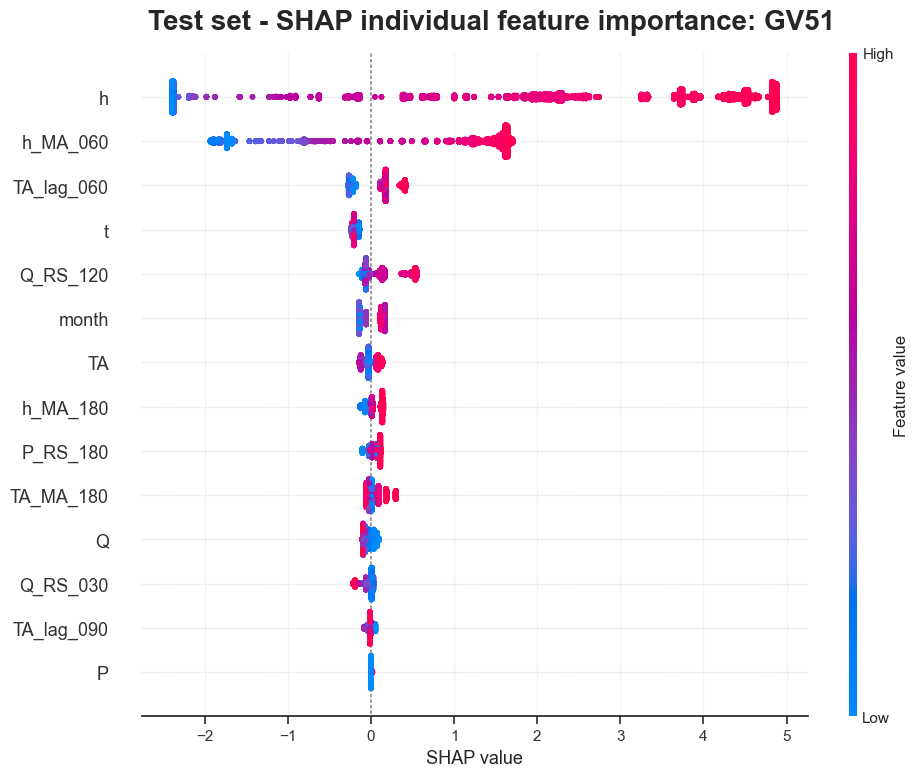

In [13]:
shap.plots.beeswarm(shap_test, max_display=36, show=False)
plt.gcf().set_size_inches(10,8)
plt.gcf().suptitle(f'Test set - SHAP individual feature importance: {target}', fontsize=20, fontweight='bold', y=0.97)

plt.tight_layout()  # Leaves space at the top for the title
plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.xlabel("SHAP value")
plt.show()

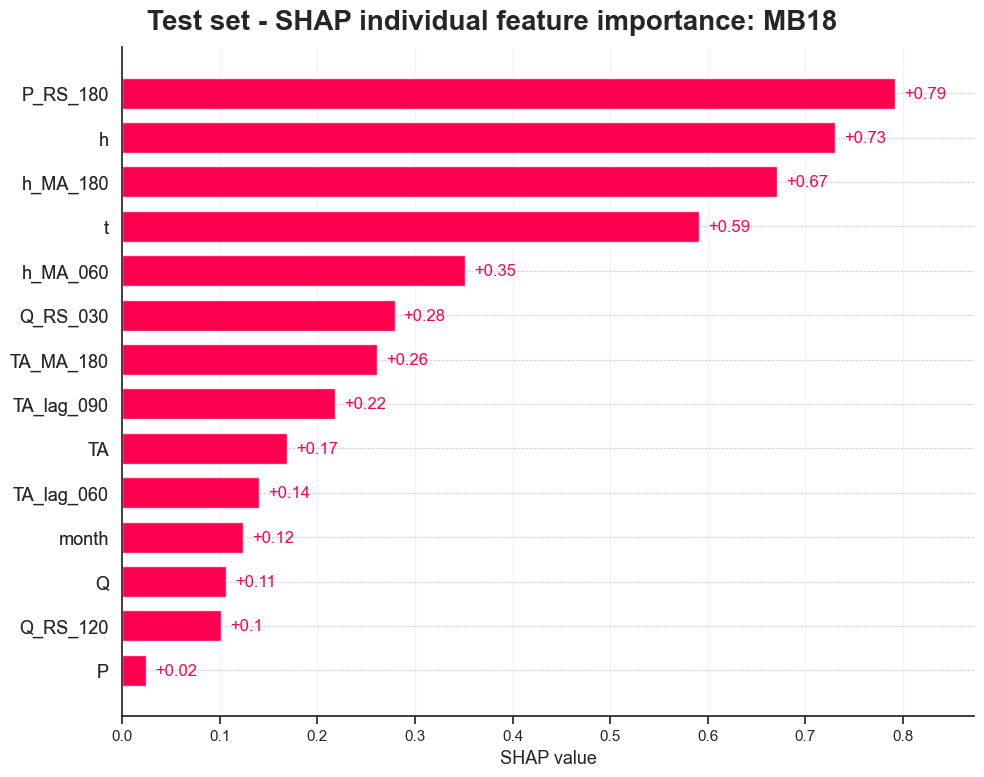

In [45]:
shap.plots.bar(shap_test, max_display=36, show=False)
plt.gcf().set_size_inches(10,8)
plt.gcf().suptitle(f'Test set - SHAP individual feature importance: {target}', fontsize=20, fontweight='bold', y=0.97)

plt.tight_layout()  # Leaves space at the top for the title
plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
# plt.xlim(-1.75, 1.75)
plt.xlabel("SHAP value")
plt.show()

In [52]:
def grouped_shap_explainer(explainer, groups, aggregation='mean'):
    """
    Creates a modified SHAP explainer object with grouped features and mean importance values (after normalization).
    
    Parameters:
    -----------
    explainer : shap.Explainer
        Original SHAP explainer object containing .values, .data, .base_values
    groups : dict
        Dictionary mapping features to their groups
    aggregation : categorical
        "mean" = mean of the SHAP importance scores. Should be used for the average importance per feature group.
        "sum" = sums the SHAP importance scores. Should be used for interpreting the magnitude of feature effects. 
                Can be biased due to different derived features and window sizes, i.e. five window sizes for h but only two for Q.
    
    Returns:
    --------
    grouped_explainer : object
        A modified explainer object with grouped features
    """
    
    # Create a new object to hold our grouped explainer
    grouped_explainer = copy.deepcopy(explainer)
    
    # Get original feature names
    features = grouped_explainer.feature_names
    revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
    
    groupmap = revert_dict(groups)

    # Group SHAP values
    shap_df = pd.DataFrame(grouped_explainer.values, columns=features)
    shap_Tdf = shap_df.T
    shap_Tdf['group'] = shap_Tdf.index.map(groupmap)
    
    if aggregation == 'mean':
        shap_grouped = shap_Tdf.groupby('group').mean().T
    elif aggregation == 'sum':
        shap_grouped = shap_Tdf.groupby('group').sum().T
    
    # Normalize and group feature values
    data_df = pd.DataFrame(grouped_explainer.data, columns=features)
    
    # Normalize each column independently
    normalized_df = pd.DataFrame(index=data_df.index)
    for col in data_df.columns:
        min_val = data_df[col].min()
        max_val = data_df[col].max()
        if max_val > min_val:  # Avoid division by zero
            normalized_df[col] = (data_df[col] - min_val) / (max_val - min_val)
        else:
            normalized_df[col] = 0
    
    # Group normalized values
    val_Tdf = normalized_df.T
    val_Tdf['group'] = val_Tdf.index.map(groupmap)
    val_grouped = val_Tdf.groupby('group').mean().T

    # Update the explainer object
    grouped_explainer.values = shap_grouped.values
    grouped_explainer.data = val_grouped.values
    grouped_explainer.feature_names = list(shap_grouped.columns)
    
    # Keep the same base values
    # grouped_explainer.base_values remains unchanged
    
    return grouped_explainer

In [53]:
# grouped_explainer_mean = grouped_shap_explainer(shap_test, all_features_grouped, aggregation='mean')
grouped_explainer_sum = grouped_shap_explainer(shap_test, all_features_grouped, aggregation='sum')

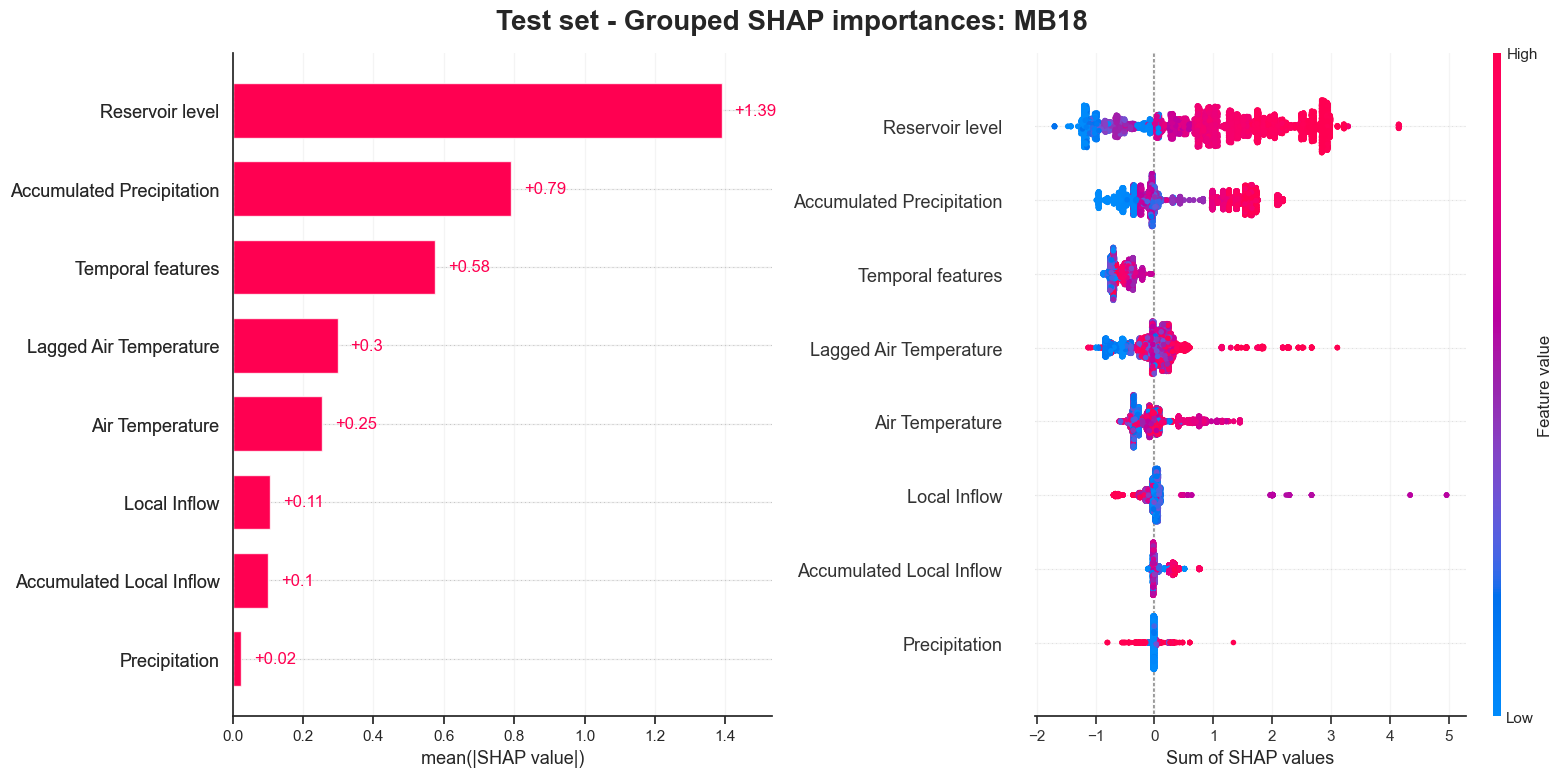

In [54]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First plot (without legend)
plt.sca(ax1)  # Set current axis
shap.plots.bar(grouped_explainer_sum, max_display=15, show=False)

plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)

# Find and remove the colorbar from the first plot
for cbar in fig.axes:
    if cbar != ax1 and cbar != ax2:
        cbar.remove()

# Second plot (with legend)
plt.sca(ax2)  # Set current axis
shap.plots.beeswarm(grouped_explainer_sum, max_display=14, show=False, plot_size=(16, 8))

plt.gcf().suptitle(f'Test set - Grouped SHAP importances: {target}', fontsize=20, fontweight='bold', y=0.97)
plt.grid(alpha=.2)
plt.xlabel("Sum of SHAP values")
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.tight_layout()
plt.show()

In [57]:
grouped_explainer_sum_all = grouped_shap_explainer(shap_all, all_features_grouped, aggregation='sum')

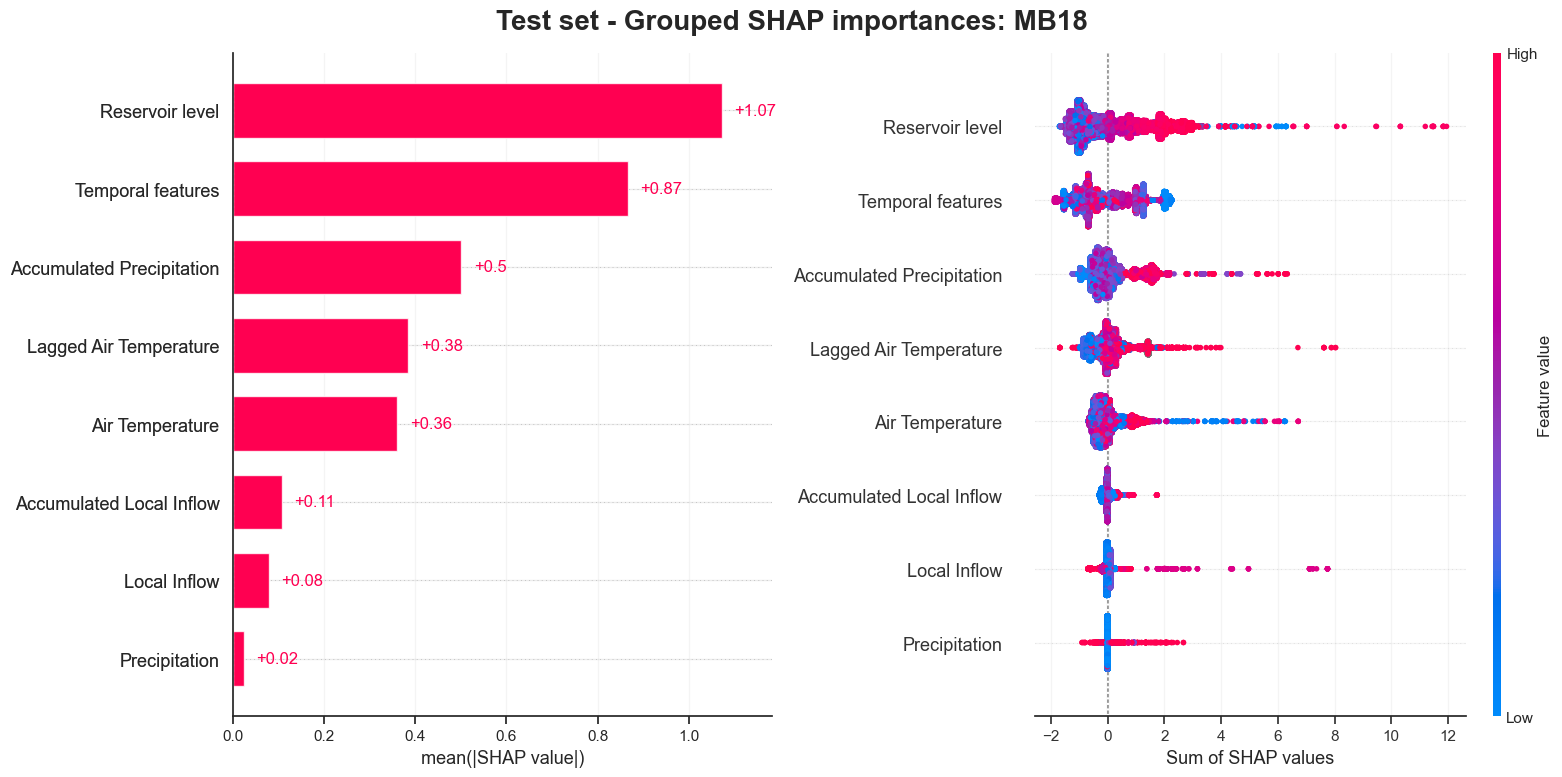

In [58]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# First plot (without legend)
plt.sca(ax1)  # Set current axis
shap.plots.bar(grouped_explainer_sum_all, max_display=15, show=False)

plt.grid(alpha=.2)
plt.axvline(x=0, linestyle=':', color='white', alpha=1)

# Find and remove the colorbar from the first plot
for cbar in fig.axes:
    if cbar != ax1 and cbar != ax2:
        cbar.remove()

# Second plot (with legend)
plt.sca(ax2)  # Set current axis
shap.plots.beeswarm(grouped_explainer_sum_all, max_display=14, show=False, plot_size=(16, 8))

plt.gcf().suptitle(f'Test set - Grouped SHAP importances: {target}', fontsize=20, fontweight='bold', y=0.97)
plt.grid(alpha=.2)
plt.xlabel("Sum of SHAP values")
plt.axvline(x=0, linestyle=':', color='white', alpha=1)
plt.tight_layout()
plt.show()

### COHORT PLOTS

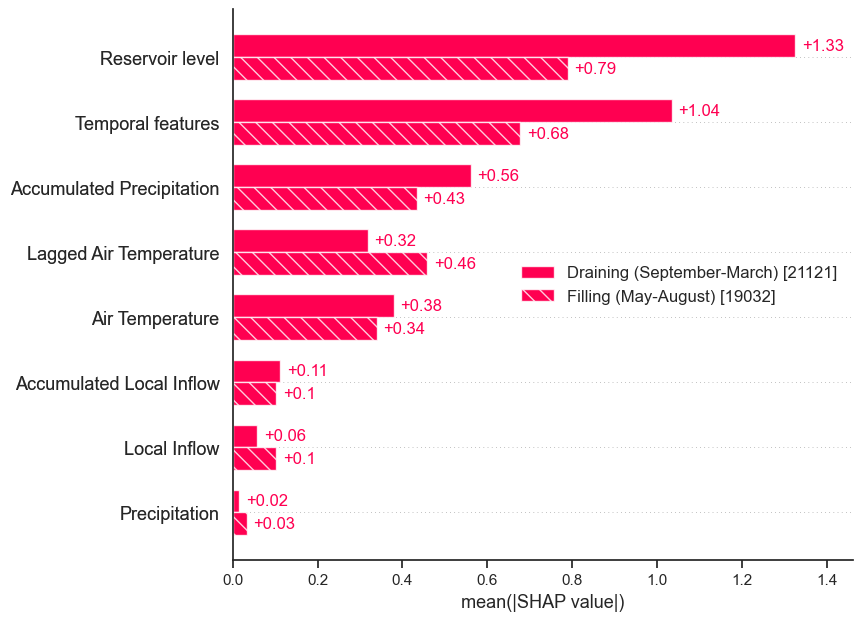

In [67]:
# Create an array of cohort labels
cohort_labels = np.array(['Filling (May-August)' if month >= 4 and month <= 9 else 'Draining (September-March)' for month in X_all['month']])

shap.plots.bar(grouped_explainer_sum_all.cohorts(cohort_labels).abs.mean(0), max_display=15)

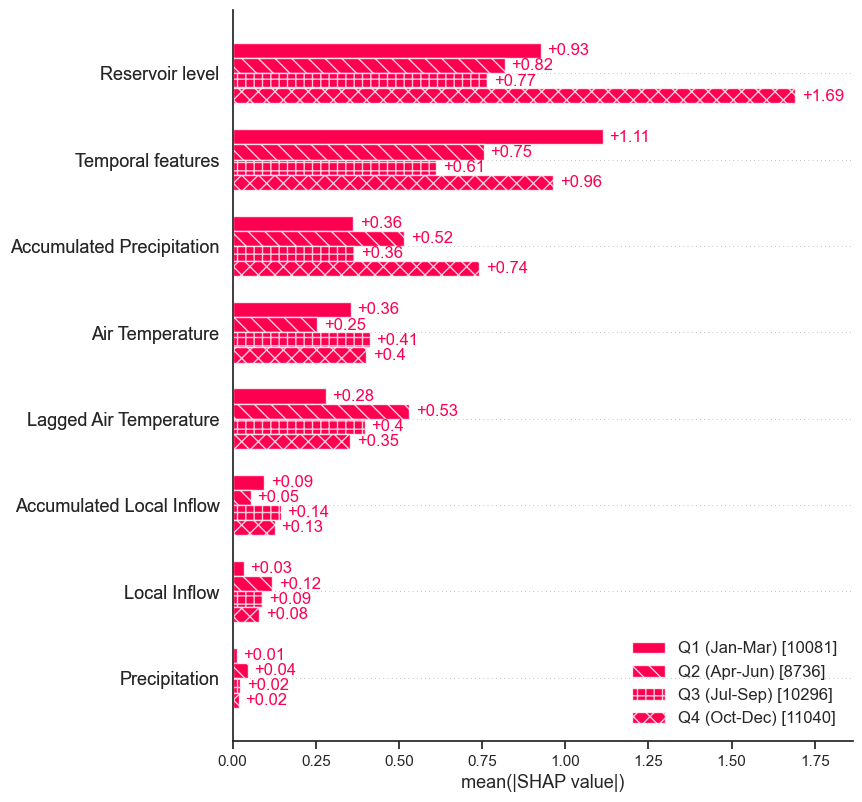

In [70]:
# Create an array of cohort labels for quarters
cohort_labels = np.array([
    'Q1 (Jan-Mar)' if 1 <= month <= 3 else
    'Q2 (Apr-Jun)' if 4 <= month <= 6 else
    'Q3 (Jul-Sep)' if 7 <= month <= 9 else
    'Q4 (Oct-Dec)' 
    for month in X_all['month']
])

# Now with four cohorts instead of two
shap.plots.bar(grouped_explainer_sum_all.cohorts(cohort_labels).abs.mean(0), max_display=15)

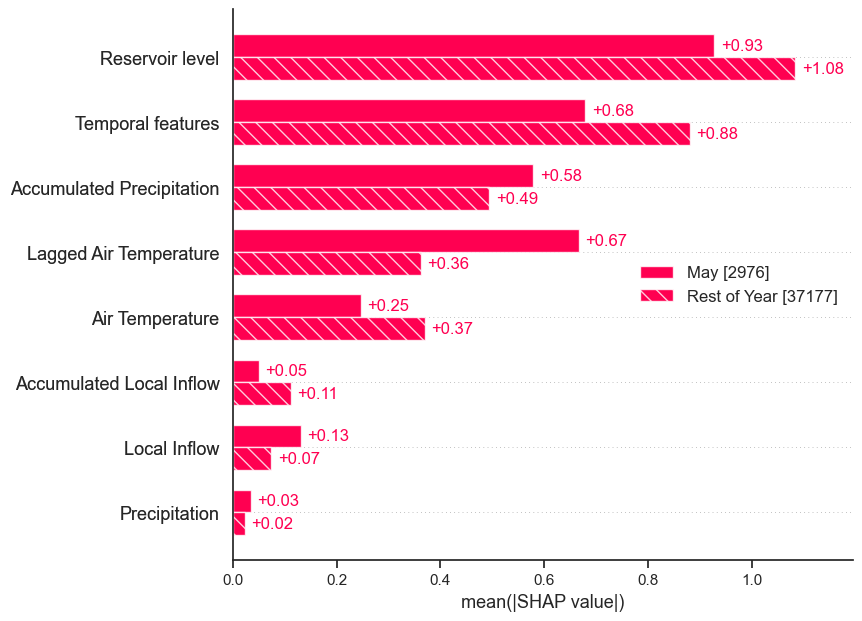

In [63]:
# Create an array of cohort labels where May is a special cohort
cohort_labels = np.array([
    'May' if month == 5 else 'Rest of Year' 
    for month in X_all['month']
])

# Compare May vs the rest of the year
shap.plots.bar(grouped_explainer_sum_all.cohorts(cohort_labels).abs.mean(0), max_display=15)

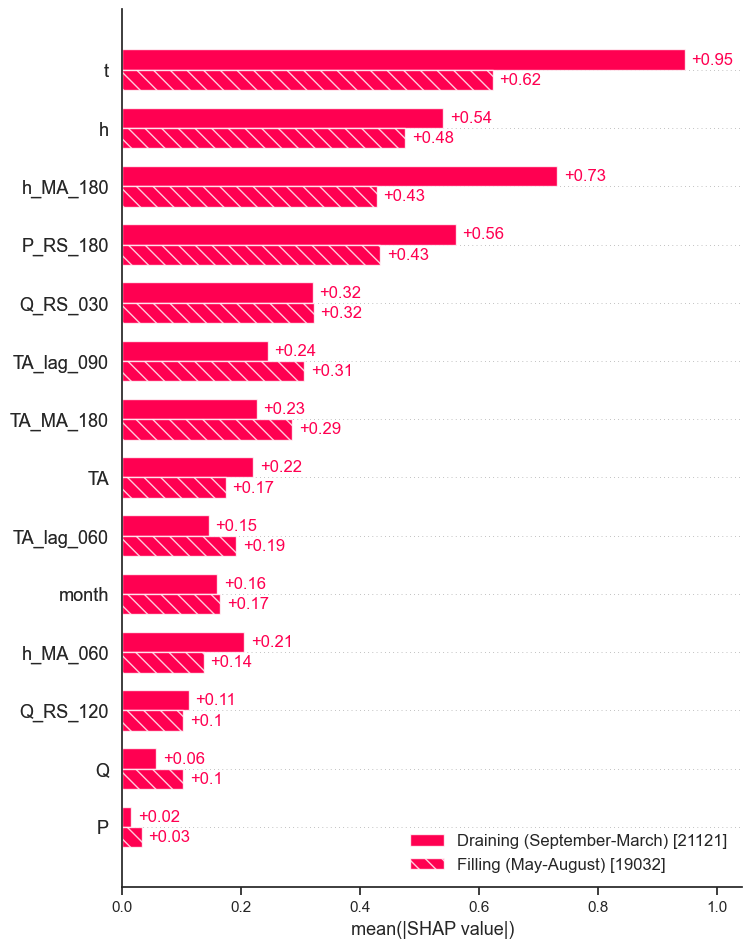

In [74]:
# Create an array of cohort labels
cohort_labels = np.array(['Filling (May-August)' if month >= 4 and month <= 9 else 'Draining (September-March)' for month in X_all['month']])

# Pass the array directly to cohorts
shap.plots.bar(shap_all.cohorts(cohort_labels).abs.mean(0), max_display=22)

## QUANTILE PLOTS

In [55]:
def shap_beeswarm_by_quantiles(shap_values_obj, study_var_idx, X_test=None, groups=None, n_quantiles=4, 
                             max_display=10, figsize=None, 
                             color=None, sort_features=True, target=None):
    """
    Create SHAP beeswarm plots for each quantile of a study variable with consistent coloring across all plots.
    
    Parameters:
    -----------
    shap_values_obj : shap.Explanation
        SHAP explanation object containing .values, .data, and .feature_names
    study_var_idx : int
        Index of the study variable in the feature set that is used to create quantiles
    X_test : pandas.DataFrame, default=None
        Original feature dataframe for calculating quartile ranges. If None, ranges are calculated from shap_values_obj
    groups : dict, default=None
        Dictionary mapping group names to lists of feature indices or names.
        If provided, features will be labeled using their group names.
    n_quantiles : int, default=4
        Number of quantiles to divide the study variable into
    max_display : int, default=10
        Maximum number of features to display
    figsize : tuple, default=None
        Figure size, will be automatically calculated if None
    color : matplotlib.colors.Colormap, default=None
        Colormap to use for the plots. If None, uses SHAP's default red-blue colormap.
    sort_features : bool, default=True
        Whether to sort features by their absolute SHAP values
    target : str, default=None
        Target variable name to include in the main title
        
    Returns:
    --------
    fig, axes : matplotlib Figure and Axes objects
    """
    # Extract data from the SHAP explanation object
    values = np.copy(shap_values_obj.values)
    features = shap_values_obj.data
    feature_names = shap_values_obj.feature_names
    
    # Handle sparse matrices
    if scipy.sparse.issparse(features):
        features = features.toarray()
    
    # Extract the study variable values for quantile calculation
    study_var = features[:, study_var_idx]
    study_var_name = feature_names[study_var_idx]
    
    # Create a reverse mapping from feature index/name to group name if groups are provided
    if groups is not None:
        # Function to reverse dictionary mapping
        revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
        group_map = revert_dict(groups)
        study_variable = groups[study_var_name][0]
        study_var_group = group_map.get(study_var_idx, study_var_name)

    # Create quantile boundaries
    q_values = np.quantile(study_var, np.linspace(0, 1, n_quantiles+1)[1:-1])
    
    # Create masks for each quantile
    quantile_masks = []
    quantile_masks.append(study_var <= q_values[0])
    for i in range(len(q_values)-1):
        mask = (study_var > q_values[i]) & (study_var <= q_values[i+1])
        quantile_masks.append(mask)
    quantile_masks.append(study_var > q_values[-1])
    
    # Calculate quartile ranges using pandas qcut if X_test is provided
    quartile_values = pd.qcut(X_test[study_variable], n_quantiles)
    quartile_ranges = [f"{interval.left:.2f}, {interval.right:.2f}" for interval in quartile_values.cat.categories]
    
    # Determine the feature order (by importance)
    if sort_features:
        feature_importance = np.mean(np.abs(values), axis=0)
        feature_order = np.argsort(-feature_importance)
    else:
        feature_order = np.arange(values.shape[1])
    
    # Limit to max_display features
    feature_inds = feature_order[:max_display]
    
    # Create figure and subplots
    if figsize is None:
        figsize = (20, max_display * 0.4 + 2)
    
    fig, axes = plt.subplots(1, n_quantiles, figsize=figsize)
    
    if n_quantiles == 1:
        axes = [axes]
    
    # Create SHAP's default red-blue colormap if none specified
    if color is None:
        # SHAP's default colors: blue (#008bfb) to magenta (#ff0051)
        colors_rgb = [(0.0, 0.5451, 0.9843), (0.8941, 0.0, 0.3176)]  # Blue to Magenta
        color = LinearSegmentedColormap.from_list("shap_red_blue", colors_rgb)
    
    # Pre-calculate global color normalization for each feature
    # This ensures consistent coloring across all subplots
    feature_vmin = {}
    feature_vmax = {}
    
    for i in feature_inds:
        feature_values = features[:, i]
        
        # Calculate percentiles, handling NaN values
        valid_values = feature_values[~np.isnan(feature_values)]
        if len(valid_values) > 0:
            vmin = np.nanpercentile(feature_values, 5)
            vmax = np.nanpercentile(feature_values, 95)
            
            # Handle edge cases
            if vmin == vmax:
                vmin = np.nanpercentile(feature_values, 1)
                vmax = np.nanpercentile(feature_values, 99)
                if vmin == vmax:
                    vmin = np.nanmin(feature_values)
                    vmax = np.nanmax(feature_values)
            
            if vmin > vmax:  # Fix numerical precision issues
                vmin = vmax
                
            feature_vmin[i] = vmin
            feature_vmax[i] = vmax
    
    # Create beeswarm plots for each quantile
    for q, (q_mask, ax) in enumerate(zip(quantile_masks, axes)):
        # Get data for this quantile
        q_vals = values[q_mask]
        q_feats = features[q_mask]
        
        # Add vertical line at x=0
        ax.axvline(x=0, color="#999999", zorder=-1)
        
        # Set title using quartile ranges and study variable text
        ax.set_title(f"Quartile {q+1}\n" + fr"${study_variable}$ = [{quartile_ranges[q]}]", fontsize=12)
        
        # Process each feature (in order)
        for pos, i in enumerate(reversed(feature_inds)):
            ax.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
            
            # Skip if no data for this quantile
            if len(q_vals) == 0 or np.sum(q_mask) == 0:
                continue
                
            # Get SHAP values and feature values for this feature
            shaps = q_vals[:, i]
            fvalues = q_feats[:, i]  # Use each feature's own values for coloring
            
            # Randomly shuffle the order of the samples
            f_inds = np.arange(len(shaps))
            np.random.shuffle(f_inds)
            fvalues = fvalues[f_inds]
            shaps = shaps[f_inds]
            
            # Create the "beeswarm" distribution
            N = len(shaps)
            nbins = 100
            
            # Avoid division by zero
            if np.max(shaps) - np.min(shaps) > 1e-8:
                quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps)))
            else:
                quant = np.zeros(N)
                
            inds_ = np.argsort(quant + np.random.randn(N) * 1e-6)
            layer = 0
            last_bin = -1
            ys = np.zeros(N)
            for ind in inds_:
                if quant[ind] != last_bin:
                    layer = 0
                ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
                layer += 1
                last_bin = quant[ind]
            
            # Scale the y values
            if np.max(ys + 1) > 0:
                ys *= 0.9 * (0.4 / np.max(ys + 1))  # 0.4 is row height
            
            # Handle NaN values in the feature
            nan_mask = np.isnan(fvalues)
            
            # Plot NaN values in gray
            if np.any(nan_mask):
                ax.scatter(
                    shaps[nan_mask],
                    pos + ys[nan_mask],
                    color="#777777",
                    s=16,
                    alpha=1.0,
                    linewidth=0,
                    zorder=3,
                    rasterized=len(shaps) > 500,
                )
            
            # Plot the non-NaN values with global color normalization for this feature
            if np.any(~nan_mask) and i in feature_vmin and i in feature_vmax:
                vmin = feature_vmin[i]
                vmax = feature_vmax[i]
                
                cvals = fvalues[~nan_mask].astype(np.float64)
                cvals_imp = cvals.copy()
                cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
                cvals[cvals_imp > vmax] = vmax
                cvals[cvals_imp < vmin] = vmin
                
                ax.scatter(
                    shaps[~nan_mask],
                    pos + ys[~nan_mask],
                    cmap=color,
                    vmin=vmin,  # Use global vmin for this feature
                    vmax=vmax,  # Use global vmax for this feature
                    s=16,
                    c=cvals,
                    alpha=1.0,
                    linewidth=0,
                    zorder=3,
                    rasterized=len(shaps) > 500,
                )
        
        # Set axis style
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("none")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.grid(True, alpha=.3)
        
        # Map feature names to group names if available
        if groups is not None:
            feature_names_to_display = []
            for i in reversed(feature_inds):
                feature_name = feature_names[i]
                if isinstance(list(groups.values())[0][0], int):
                    # Groups contain indices
                    group_name = group_map.get(i, feature_name)
                else:
                    # Groups contain names
                    group_name = group_map.get(feature_name, feature_name)
                feature_names_to_display.append(group_name)
        else:
            feature_names_to_display = [feature_names[i] for i in reversed(feature_inds)]
        
        # Only show y-labels on the first subplot
        if q > 0:
            ax.set_yticks(range(len(feature_inds)), [])
        else:
            ax.set_yticks(range(len(feature_inds)), feature_names_to_display, fontsize=13)
            
        ax.tick_params("y", length=20, width=0.5, which="major")
        ax.tick_params("x", labelsize=11)
        ax.set_ylim(-1, len(feature_inds))
        ax.set_xlabel("SHAP value", fontsize=13)
    
    # Add a colorbar on the right
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.005, 0.7])  # [left, bottom, width, height]
    
    # Create a colorbar that represents feature values (general)
    m = cm.ScalarMappable(cmap=color)
    m.set_array([])
    cbar = fig.colorbar(m, cax=cbar_ax)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Low', 'High'])
    cbar.set_label("Relative feature value", size=14, labelpad=0)
    cbar.ax.tick_params(labelsize=11, length=0)
    cbar.set_alpha(1)
    cbar.outline.set_visible(False)  # Remove the black outline
    
    # Add a title for the entire figure including target if provided
    title = f"SHAP Values by Quartiles of {study_var_group}"
    if target:
        title += f": {target}"
    fig.suptitle(title, fontsize=20, fontweight='bold')
    
    return fig, axes

In [56]:
explainer = shap.TreeExplainer(LGBM_model)
shap_all =  explainer(X_all)

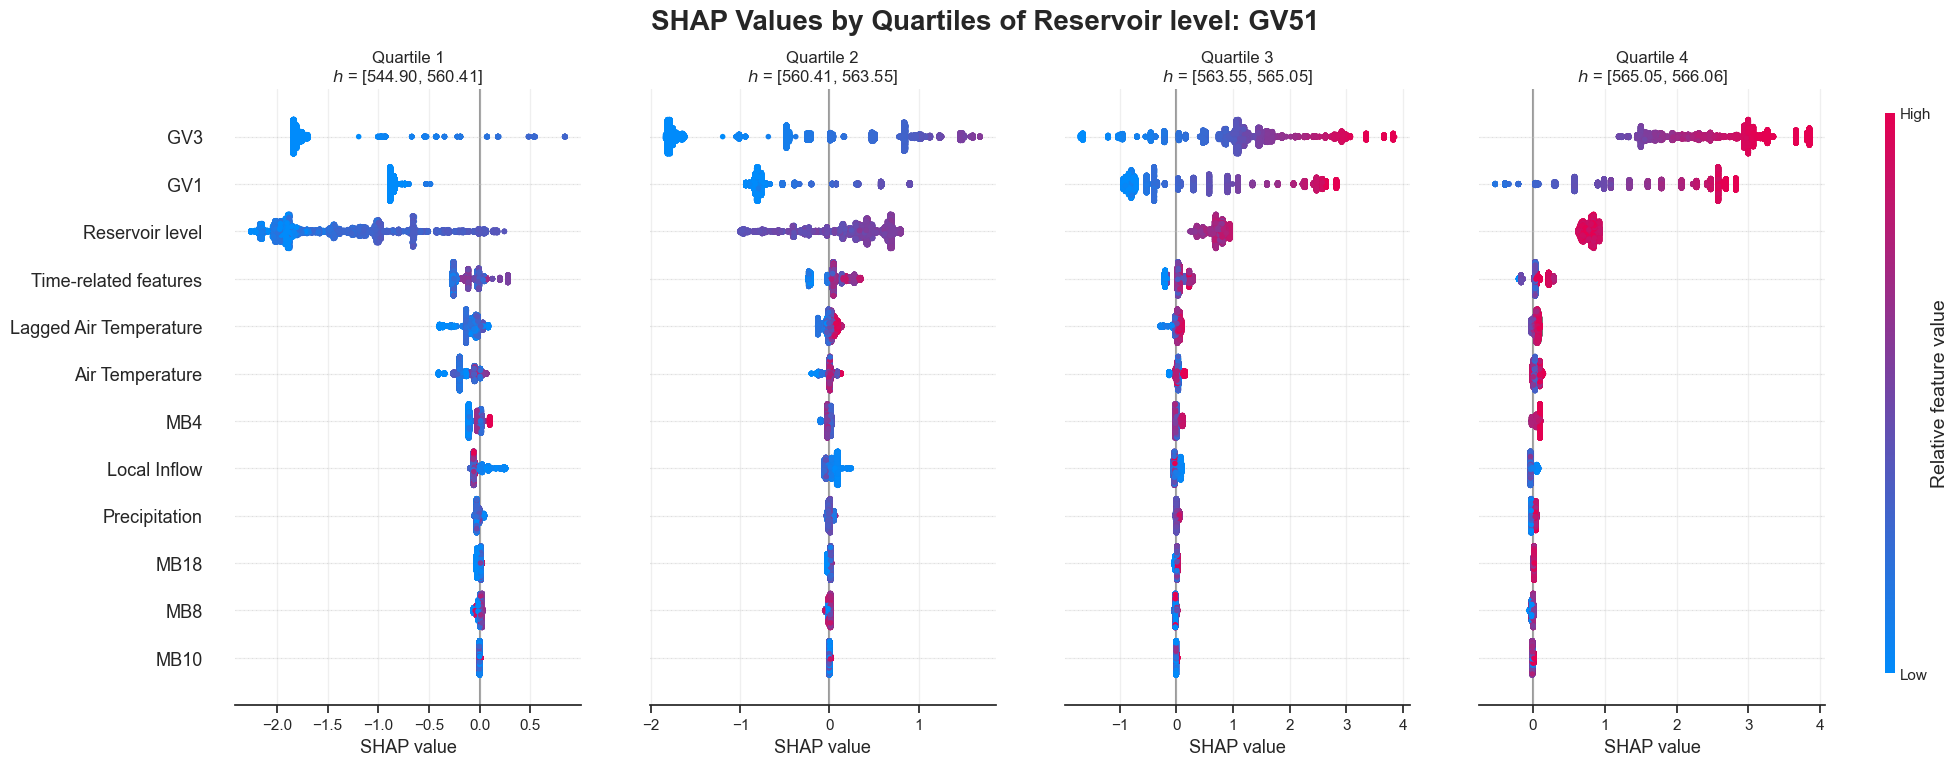

In [ ]:
grouped_shap = grouped_shap_explainer(shap_all, all_features_grouped, aggregation='sum')

shap_values_to_plot = grouped_shap
feature_names = grouped_shap.feature_names

study_var_idx = 10  # change this to your study variable index

print(feature_names)
print(feature_names[study_var_idx])

fig, axes = shap_beeswarm_by_quantiles(
    shap_values_to_plot, 
    study_var_idx,
    X_test=X_test,
    groups=all_features_grouped,
    n_quantiles=4,
    max_display=13,
    figsize=(20, 8),
    target=target
)
plt.show()

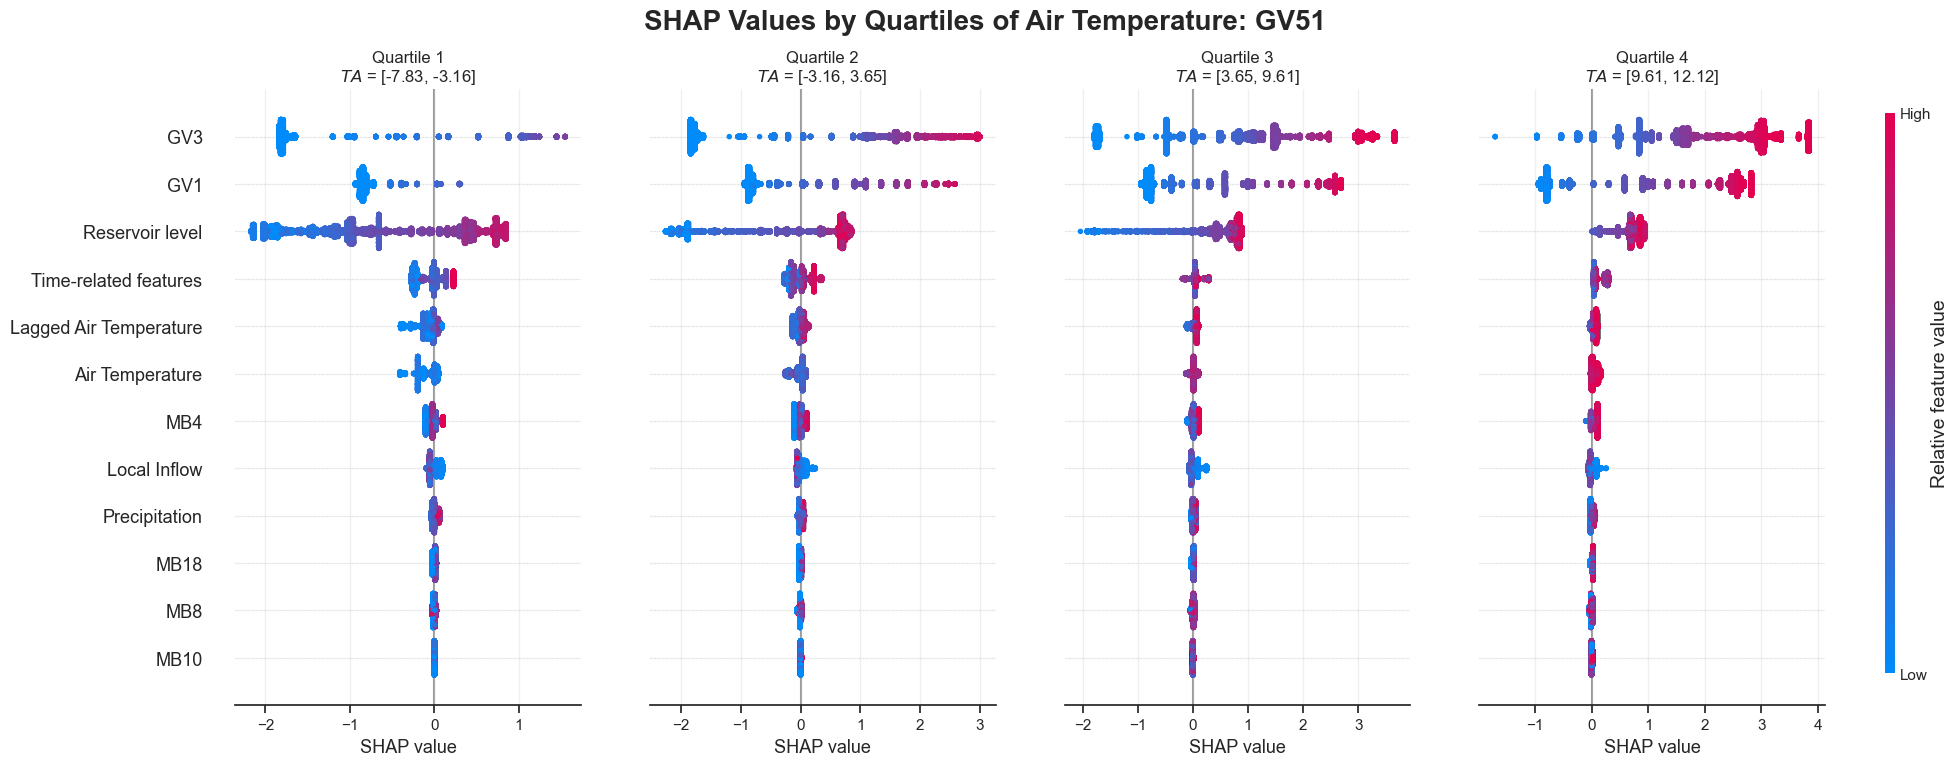

In [73]:
grouped_shap = grouped_shap_explainer(shap_test, all_features_grouped, aggregation='sum')

shap_values_to_plot = grouped_shap
feature_names = grouped_shap.feature_names

study_var_idx = 0  # change this to your study variable index

fig, axes = shap_beeswarm_by_quantiles(
    shap_values_to_plot, 
    study_var_idx,
    X_test=X_test,
    groups=all_features_grouped,
    n_quantiles=4,
    max_display=13,
    figsize=(20, 8),
    target=target
)
plt.show()

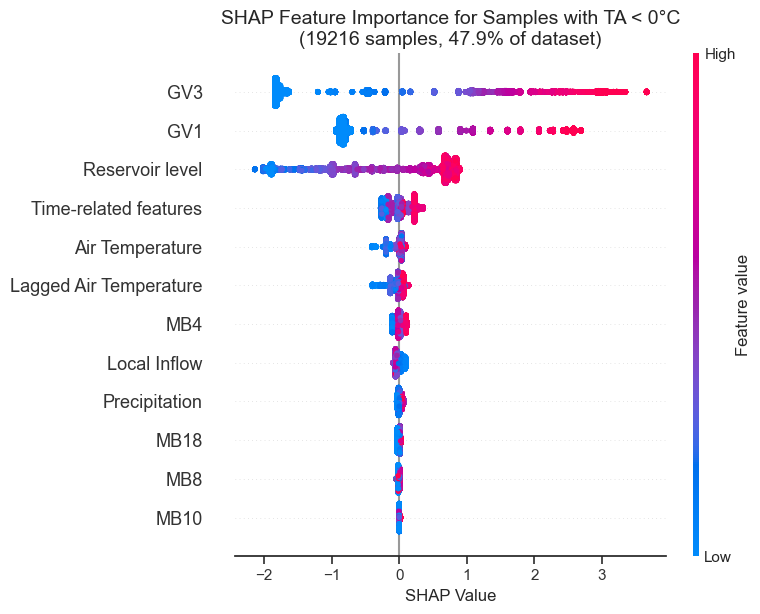

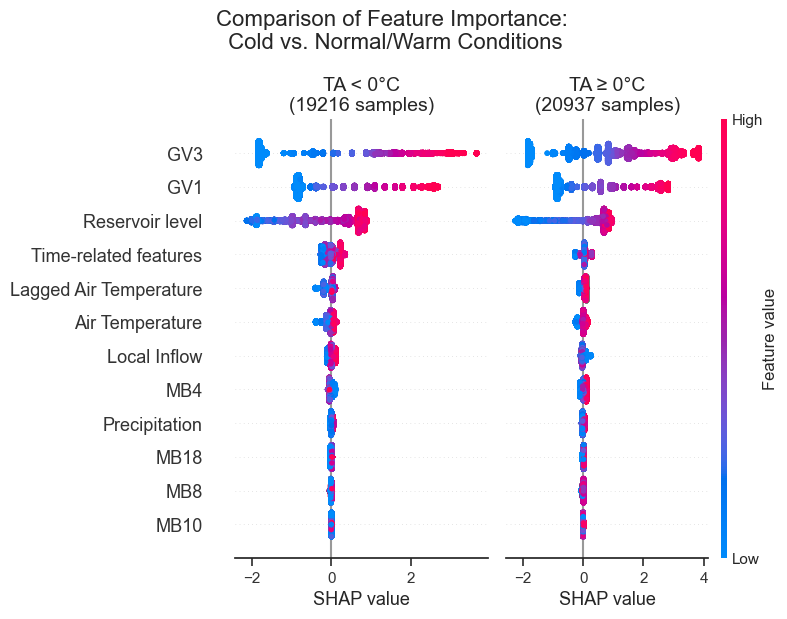

In [78]:
grouped_shap = grouped_shap_explainer(shap_all, all_features_grouped, aggregation='sum')

# Create a boolean mask for samples where TA < 0
cold_temp_mask = np.array(X_all['TA'] < 0)

# print(np.array(cold_temp_mask))

# Count how many samples meet the condition
sample_count = cold_temp_mask.sum()
total_samples = len(X_all)
percentage = (sample_count / total_samples) * 100

# Create the plot
plt.figure(figsize=(12, 8))

# Apply the mask to both SHAP values and feature values
if sample_count > 0:
    # Create SHAP beeswarm plot for only the cold temperature samples
    shap.plots.beeswarm(
        grouped_shap[cold_temp_mask],
        show=False,
        max_display=15  # Adjust as needed
    )
    
    # Add an informative title
    plt.title(f'SHAP Feature Importance for Samples with TA < 0°C\n({sample_count} samples, {percentage:.1f}% of dataset)', 
              fontsize=14)
    
    # Improve axis labels
    plt.xlabel('SHAP Value', fontsize=12)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No samples found with TA < 0°C in the dataset.")

# Optional: You can also create a comparison plot showing both cold and normal conditions
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot cold conditions (TA < 0)
plt.sca(ax[0])
if cold_temp_mask.sum() > 0:
    shap.plots.beeswarm(
        grouped_shap[cold_temp_mask],
        show=False,
        max_display=15,
        color_bar=False
    )
    ax[0].set_title(f'TA < 0°C\n({sample_count} samples)', fontsize=14)
    ax[0].set_xlabel('SHAP value')

# Plot normal/warm conditions (TA >= 0)
plt.sca(ax[1])
warm_temp_mask = ~cold_temp_mask
if warm_temp_mask.sum() > 0:
    shap.plots.beeswarm(
        grouped_shap[warm_temp_mask],
        show=False,
        max_display=15
    )
    ax[1].set_title(f'TA ≥ 0°C\n({warm_temp_mask.sum()} samples)', fontsize=14)
    ax[1].set_xlabel('SHAP value')

# Set a common title
fig.suptitle('Comparison of Feature Importance:\n Cold vs. Normal/Warm Conditions', fontsize=16)

# Adjust layout and display
plt.tight_layout()
plt.show()

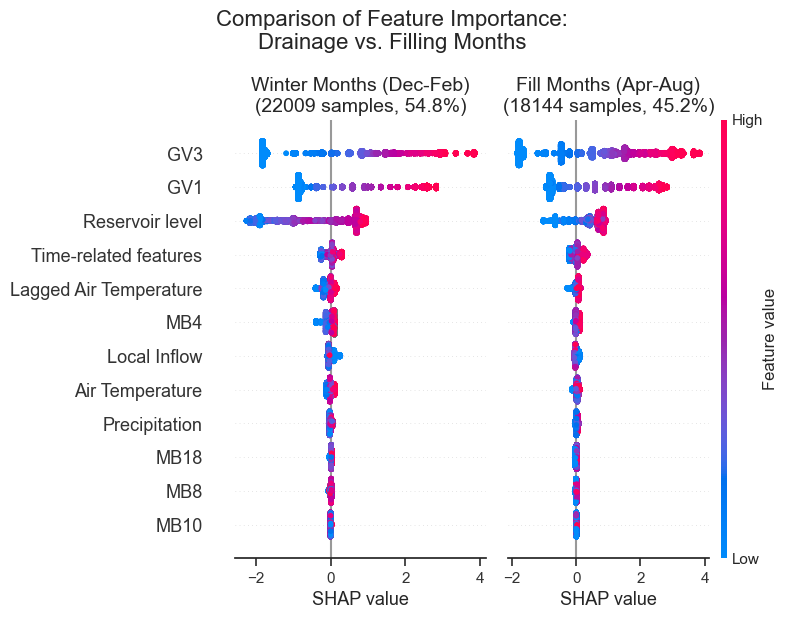

In [105]:
# Define your time-based masks - for example, to compare winter vs. summer months
# Assuming 'month' is numeric (1-12)
# Create mask for months between February and August (inclusive)
before_aug = np.array((X_all['month'] >= 3) & (X_all['month'] <= 9))  # Feb-Aug

# Create mask for months outside Feb-Aug (i.e., Sep, Oct, Nov, Dec, Jan)
after_aug = np.array(~before_aug)  # This is the correct way to invert the mask

# Count samples in each group
winter_count = before_aug.sum()
summer_count = after_aug.sum()
total_samples = len(X_all)
winter_percentage = (winter_count / total_samples) * 100
summer_percentage = (summer_count / total_samples) * 100

# Calculate SHAP values for each group separately before grouping
winter_shap = shap_all[before_aug]
summer_shap = shap_all[after_aug]

# Apply the grouped SHAP explainer to each masked dataset
winter_grouped_shap = grouped_shap_explainer(winter_shap, all_features_grouped, aggregation='sum')
summer_grouped_shap = grouped_shap_explainer(summer_shap, all_features_grouped, aggregation='sum')

# Create the comparison plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot winter conditions
plt.sca(ax[0])
if winter_count > 0:
    shap.plots.beeswarm(
        winter_grouped_shap,
        show=False,
        max_display=15,
        color_bar=False
    )
    ax[0].set_title(f'Winter Months (Dec-Feb)\n({winter_count} samples, {winter_percentage:.1f}%)', fontsize=14)
    ax[0].set_xlabel('SHAP value')

# Plot summer conditions
plt.sca(ax[1])
if summer_count > 0:
    shap.plots.beeswarm(
        summer_grouped_shap,
        show=False,
        max_display=15
    )
    ax[1].set_title(f'Fill Months (Apr-Aug)\n({summer_count} samples, {summer_percentage:.1f}%)', fontsize=14)
    ax[1].set_xlabel('SHAP value')

# Set a common title
fig.suptitle('Comparison of Feature Importance:\nDrainage vs. Filling Months', fontsize=16)

# Adjust layout and display
plt.tight_layout()
plt.show()

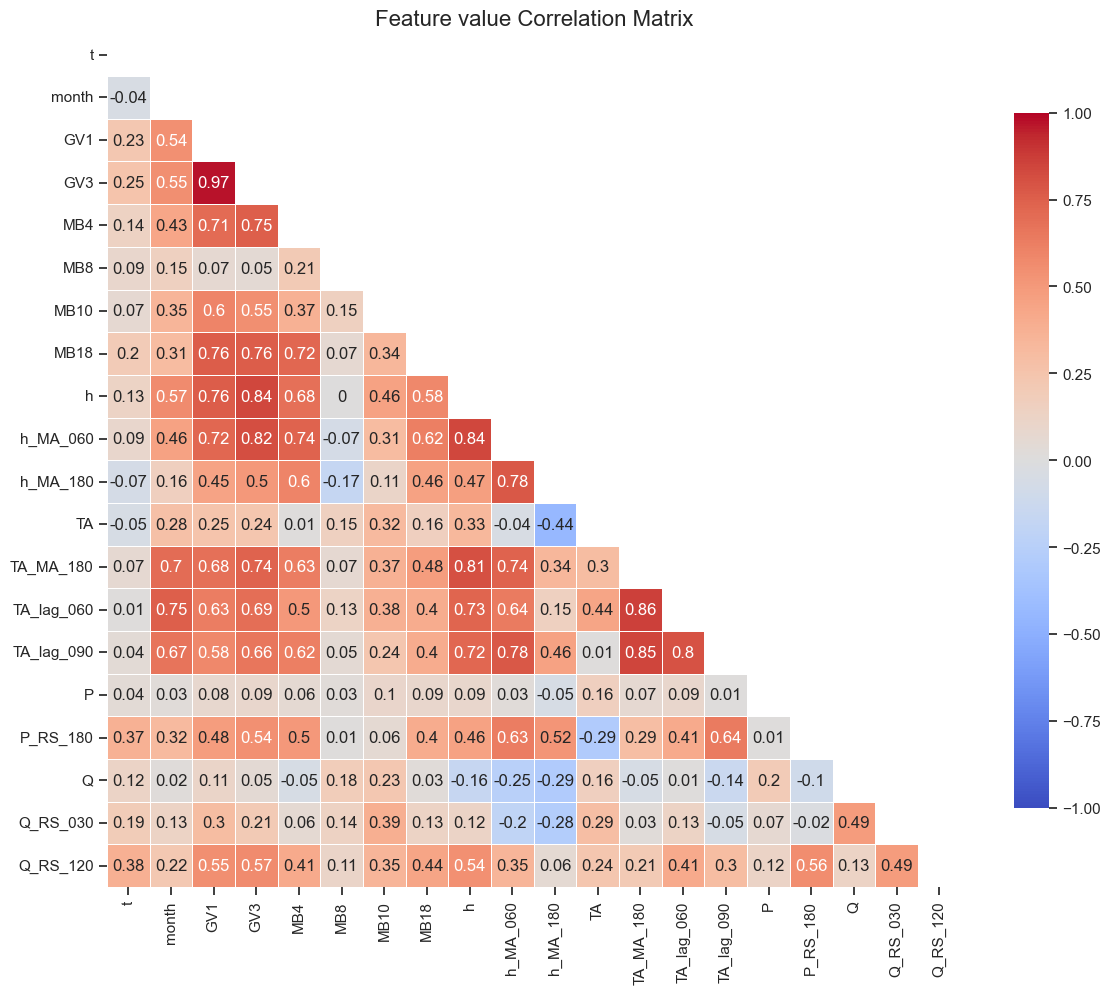

In [ ]:
# Step 1: Convert SHAP values to a DataFrame
X_values_df = pd.DataFrame(
    X.values, 
    columns=X.columns
)

# Step 2: Calculate the correlation matrix
X_correlation = np.round(X_values_df.corr(),2)

# Step 3: Create the heatmap
plt.figure(figsize=(12, 10))
threshold = 0.5
# correlation_mask = np.abs(X_correlation) < threshold

triangle_mask = np.triu(np.ones_like(X_correlation, dtype=bool))
# combined_mask = np.logical_or(correlation_mask, triangle_mask)


# Create the heatmap
sns.heatmap(
    X_correlation, 
    mask=triangle_mask,  # Optional: uncomment to show only lower triangle
    annot=True,  # Show correlation values
    cmap='coolwarm',  # Color scheme
    vmin=-1, vmax=1,  # Value range
    center=0,  # Center the colormap at zero
    square=True,  # Make cells square
    linewidths=.5,  # Add lines between cells
    cbar_kws={"shrink": .8}  # Colorbar size
)

plt.title('Feature value Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

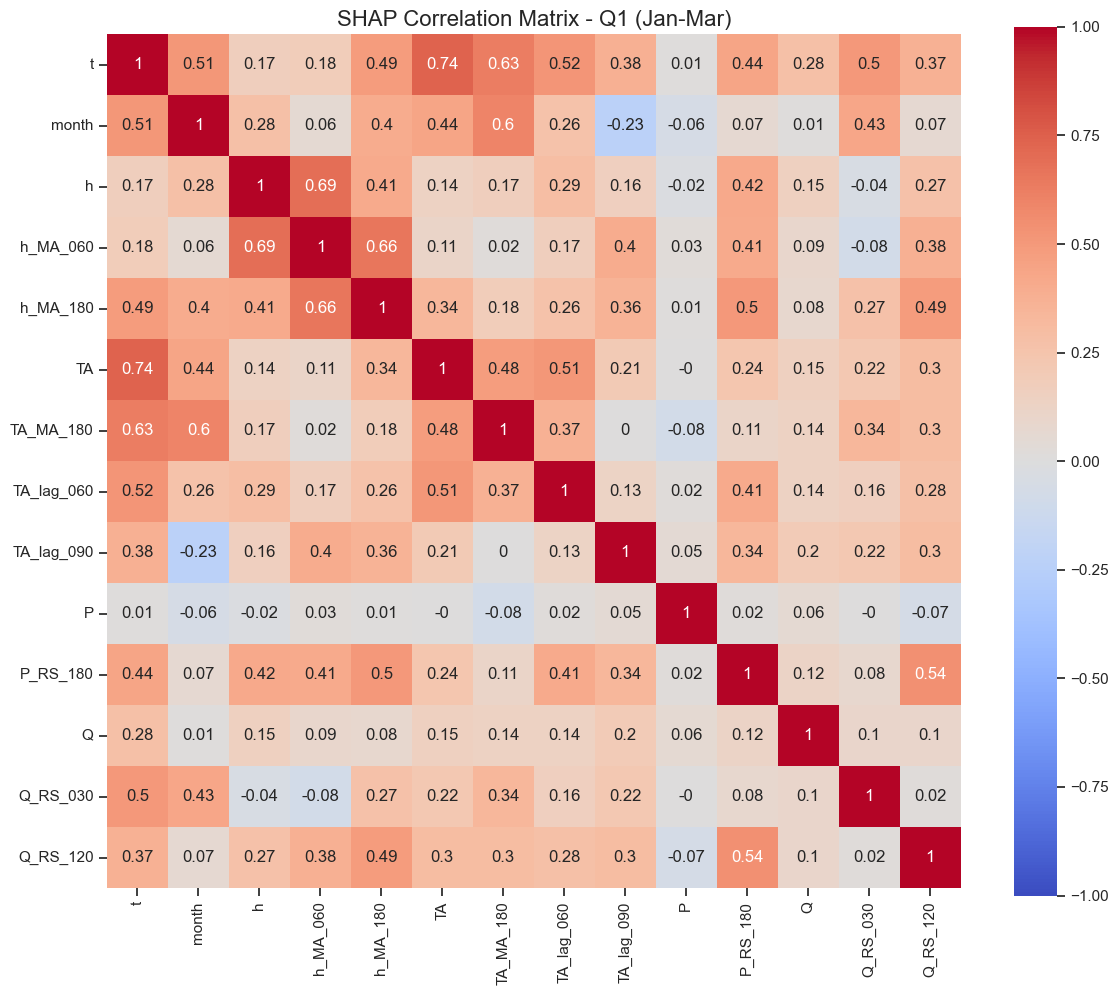

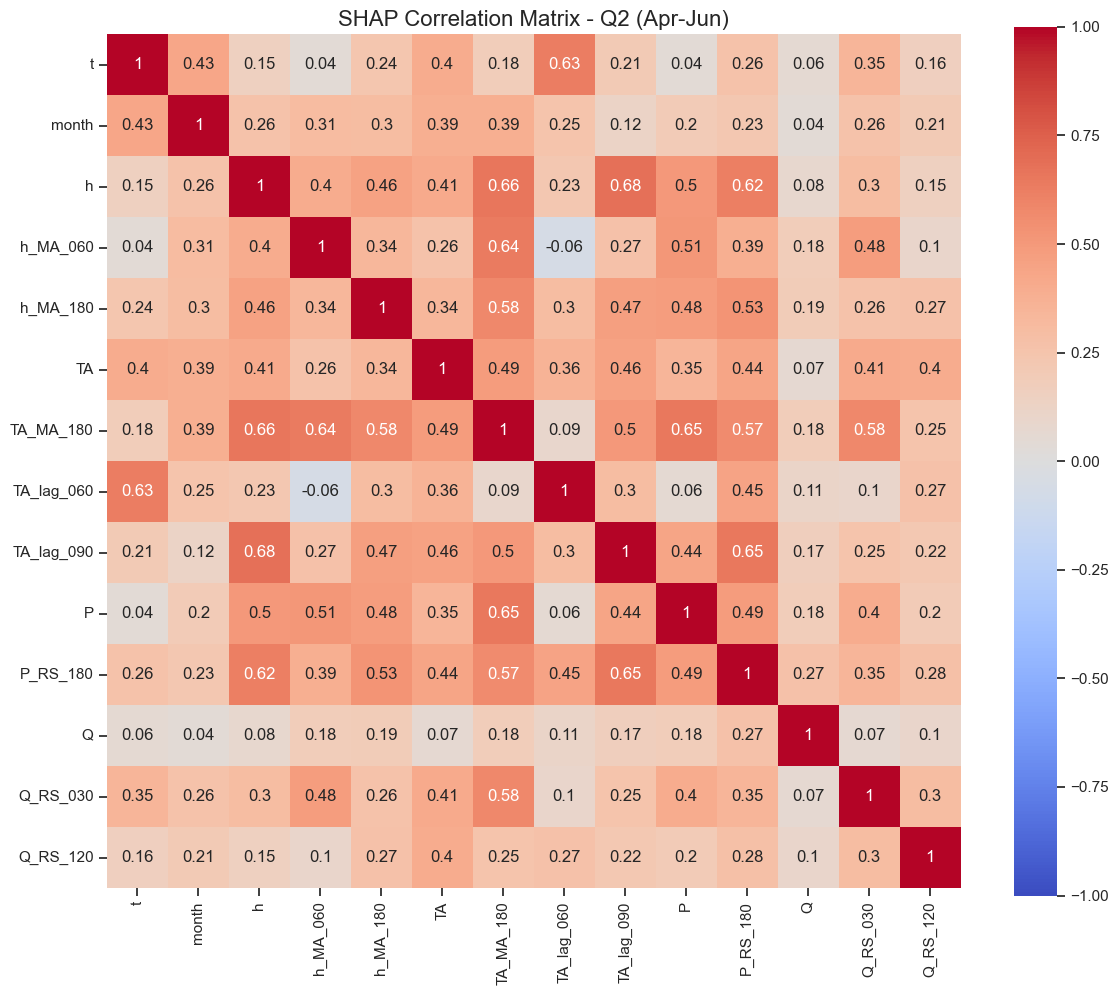

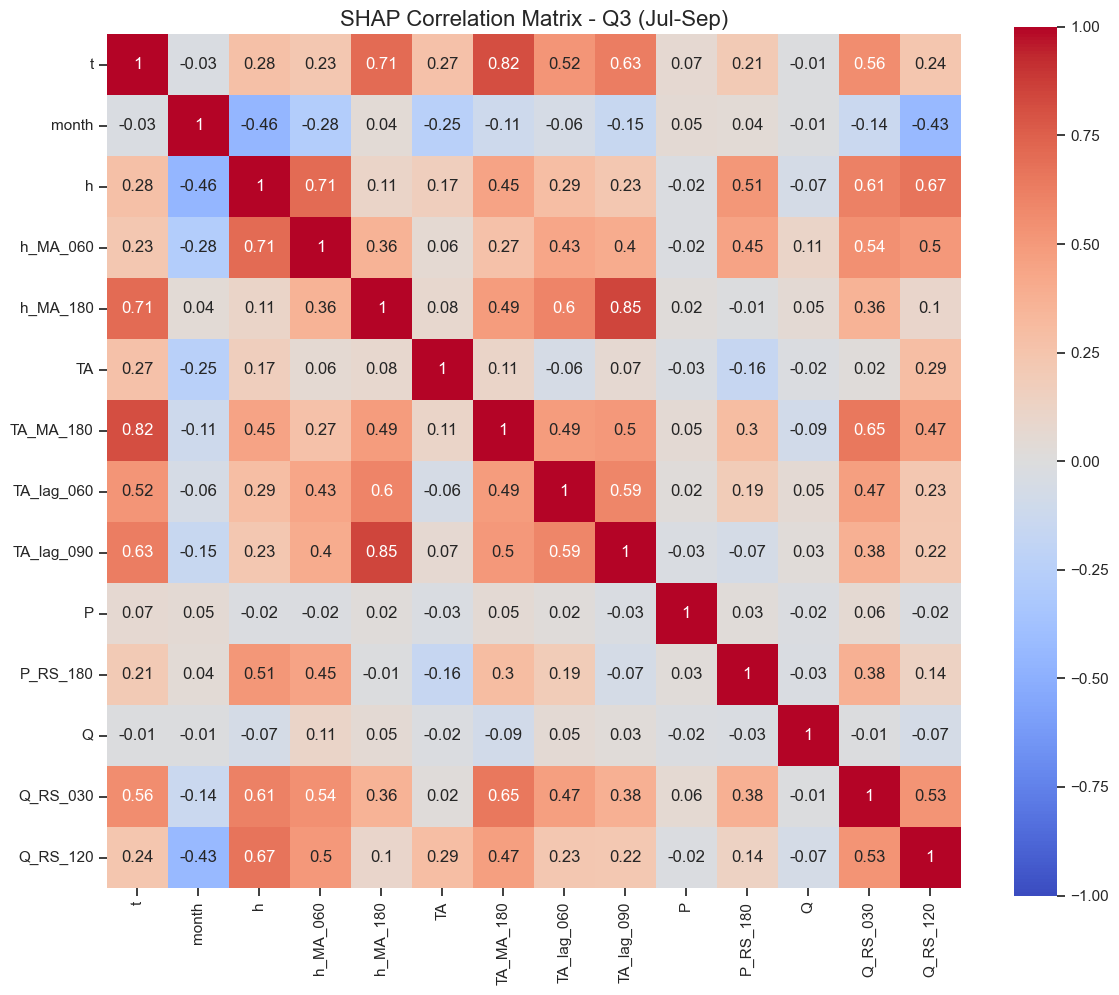

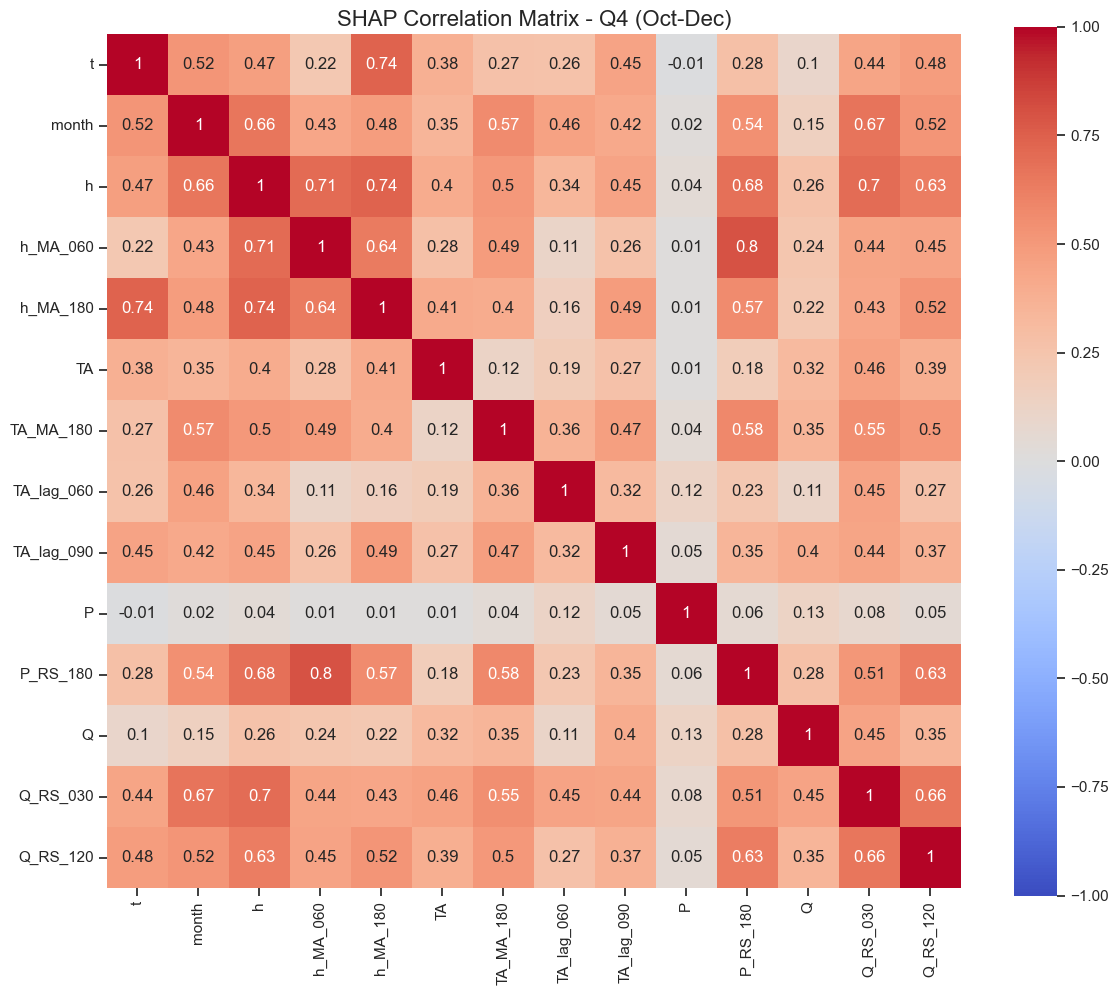

In [71]:
# Create correlation matrices for each cohort
for cohort_name in np.unique(cohort_labels):
    cohort_mask = cohort_labels == cohort_name
    
    # Get SHAP values for this cohort
    cohort_shap_values = shap_all[cohort_mask].values
    
    # Convert to DataFrame
    cohort_shap_df = pd.DataFrame(
        cohort_shap_values, 
        columns=X_all.columns
    )
    
    # Calculate correlation
    cohort_correlation = np.round(cohort_shap_df.corr(),2)
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cohort_correlation,
        annot=True,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True
    )
    
    plt.title(f'SHAP Correlation Matrix - {cohort_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

## **LOCAL EXPLANATIONS**

Here, we want to study the prediciton instance on different scales:
- Compared to last week
- Compared to last year, same hour
- Compared to last year, same day
- Compared to last year, same week(?)
- Compared to the same month of last year(?)

For this, we need to pass a reference dataset to SHAP for which the explainer is constructed on. From the SHAP doc's:

*"Since SHAP values rely on conditional expectations, we need to decide how to handle correlated (or otherwise dependent) input features. if "interventional", a background dataset data is required. The dependencies between features are handled according to the rules dictated by causal inference. The runtime scales linearly with the size of the background dataset you use: anywhere from 100 to 1000 random background samples are good sizes to use."*

In [ ]:
print(X_test)
print(len(X_test))
print(len(X))
print(split_index)

In [ ]:
print(X_all[split_index-len(X_test):split_index])

In [ ]:
print(dates)

In [ ]:
print(y_test)

In [ ]:
sns.histplot(y[split_index-len(y_test):split_index], bins=20, kde=True, color='blue')  # type: ignore
plt.title(f'Train distribution of {target}, preceding last year', fontsize=16)
plt.xlabel(f'{target} ({determine_unit(target)})', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

In [ ]:
sns.histplot(y_test, bins=20, kde=True, color='blue')  # type: ignore
plt.title(f'Test distribution of {target}', fontsize=16)
plt.xlabel(f'{target} ({determine_unit(target)})', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

In [ ]:
reference_X_train_data = X_train[split_index-len(X_test):split_index]

In [ ]:
# Plotting all water levels data (GW pipes + ÖVY reservoir water level)
plt.clf()
plt.figure(figsize=(10, 6))

reference_y_train_data = y_train[split_index-len(y_test):split_index]

mean_reference_y = np.mean(y[split_index-len(y_test):split_index])
print(f"Expected (mean) value of reference data: {mean_reference_y}")

plt.plot(dates, y, label=mapping(target), alpha=.2, color='gray')
plt.plot(dates[split_index:], y_test, label='Test data', color='red')
plt.plot(dates[split_index-len(y_test):split_index], reference_y_train_data, label='1-year precendent reference data', color='green')
plt.axhline(y=mean_reference_y, linestyle=':', linewidth=2, label='Expected (mean) value of reference')
# plt.text(0.05, 0.05, rf"E[f(x)]={mean_reference_y}", verticalalignment='top', fontweight='bold', fontsize=16)
plt.tick_params(axis='x', rotation=45)
plt.ylabel(f'{target} level ({determine_unit(target)})')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

In [ ]:
previous_year_X_train = X_all[split_index-len(X_test):split_index]

In [ ]:
%%time
previous_year_X_train = X_all[split_index-len(X_test):split_index]
explainer_local = shap.TreeExplainer(LGBM_model, feature_perturbation='interventional', data=previous_year_X_train[:100], model_output='raw')

In [ ]:
shap_local =  explainer_local(X_test[:100])

In [ ]:
def grouped_shap_explainer_local(explainer, groups, aggregation='mean', use_first_feature=True, verbose=False):
    """
    Creates a modified SHAP explainer object with grouped features and aggregated importance values.
    Ensures proper alignment for waterfall plots.
    
    Parameters:
    -----------
    explainer : shap.Explainer
        Original SHAP explainer object containing .values, .data, .base_values
    groups : dict
        Dictionary mapping feature groups to their features, where the first feature in each group
        is assumed to be the original/non-derived feature
    aggregation : str
        "mean" = mean of the SHAP importance scores. Should be used for the average importance per feature group.
        "sum" = sums the SHAP importance scores. Should be used for interpreting the magnitude of feature effects.
        Can be biased due to different derived features and window sizes, i.e. five window sizes for h but only two for Q.
    use_first_feature : bool
        If True, uses the value of only the first feature in each group for the data attribute
        If False, normalizes and averages values across all features in the group
    
    Returns:
    --------
    grouped_explainer : object
        A modified explainer object with grouped features, properly aligned for waterfall plots
    """
    import copy
    import pandas as pd
    import numpy as np
    from itertools import chain, repeat
    
    # Create a new object to hold our grouped explainer
    grouped_explainer = copy.deepcopy(explainer)
    
    # Get original feature names
    features = grouped_explainer.feature_names
    revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
    
    # Create a mapping from feature to group
    groupmap = revert_dict(groups)
    if verbose:
        print("Feature to group mapping:", groupmap)
    
    # Group SHAP values
    shap_df = pd.DataFrame(grouped_explainer.values, columns=features)
    shap_Tdf = shap_df.T
    shap_Tdf['group'] = shap_Tdf.index.map(groupmap)
    
    if aggregation == 'mean':
        shap_grouped = shap_Tdf.groupby('group').mean().T
    elif aggregation == 'sum':
        shap_grouped = shap_Tdf.groupby('group').sum().T
    
    # Get the feature names in the correct order after grouping
    grouped_feature_names = list(shap_grouped.columns)
    
    # Get the data feature values
    data_df = pd.DataFrame(grouped_explainer.data, columns=features)
    
    if use_first_feature:
        # Create a mapping from group to its first (original) feature
        first_features = {group: feature_list[0] for group, feature_list in groups.items()}
        if verbose:
            print("First feature in each group:", first_features)
        
        # Create a new DataFrame with the same order as shap_grouped
        val_grouped = pd.DataFrame(index=data_df.index, columns=grouped_feature_names)
        
        # For each group, use the value of the first feature
        for group in grouped_feature_names:
            if group in first_features and first_features[group] in data_df.columns:
                # Use the original feature value
                val_grouped[group] = data_df[first_features[group]]
            else:
                print(f"Warning: Feature '{group}' or its first feature not found in data")
                # Use zeros as fallback
                val_grouped[group] = 0
    else:
        # Original approach: normalize and average all features in each group
        # Normalize each column independently
        normalized_df = pd.DataFrame(index=data_df.index)
        for col in data_df.columns:
            min_val = data_df[col].min()
            max_val = data_df[col].max()
            if max_val > min_val:  # Avoid division by zero
                normalized_df[col] = (data_df[col] - min_val) / (max_val - min_val)
            else:
                normalized_df[col] = 0
        
        # Group normalized values
        val_Tdf = normalized_df.T
        val_Tdf['group'] = val_Tdf.index.map(groupmap)
        val_grouped_temp = val_Tdf.groupby('group').mean().T
        
        # Ensure the columns order matches shap_grouped
        val_grouped = pd.DataFrame(index=val_grouped_temp.index, columns=grouped_feature_names)
        for col in grouped_feature_names:
            if col in val_grouped_temp.columns:
                val_grouped[col] = val_grouped_temp[col]
            else:
                val_grouped[col] = 0
    
    # Double-check that the column ordering matches
    assert all(shap_grouped.columns == val_grouped.columns), "Column mismatch between SHAP values and feature data"
    
    # Update the explainer object
    grouped_explainer.values = shap_grouped.values
    grouped_explainer.data = val_grouped.values
    grouped_explainer.feature_names = grouped_feature_names
    
    if verbose:
        print(f"Grouped explainer created with {len(grouped_feature_names)} feature groups")
    
    return grouped_explainer

In [ ]:
grouped_local_explainer = grouped_shap_explainer_local(
    shap_local, 
    features_local_explanation, 
    aggregation='sum',
    use_first_feature=True  # Use only the original features
)

In [ ]:
grouped_local_explainer.shape[0]

In [ ]:
shap.plots.bar(grouped_local_explainer.cohorts(2).abs.mean(0))

In [ ]:
plt.figure(figsize=(5,5))
shap.plots.waterfall(grouped_local_explainer[5000], max_display=15)

In [ ]:
# Plotting all water levels data (GW pipes + ÖVY reservoir water level)
plt.clf()
plt.figure(figsize=(10, 6))

instance_index = split_index + 5000

plt.plot(dates, y, label=mapping(target), alpha=.2, color='gray')
plt.plot(dates[split_index:], y_test, label='Test data', color='red')
plt.plot(dates[split_index-len(y_test):split_index], y[split_index-len(y_test):split_index], label='1-year precendent reference', color='green')
plt.axvline(x=dates.iloc[instance_index], color='purple', alpha=0.5, linestyle=':')
plt.scatter(x=dates.iloc[instance_index], y=y_test[instance_index], color='purple', s=100, marker='*', zorder=5, label="Instance to explain")
plt.tick_params(axis='x', rotation=45)
plt.ylabel(f'{target} level ({determine_unit(target)})')
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

### REFERENCE DATA CONSISTING OF PERIODS WITH SIMILAR (LOW/MEDIUM/HIGH) RESERVOIR WATER LEVEL

In [ ]:
# Plotting all water levels data (GW pipes + ÖVY reservoir water level)
plt.clf()
plt.figure(figsize=(10, 6))

reference_h_train_data = X_train["h"][split_index-len(X_test):split_index]

q1_h = reference_h_train_data.quantile(0.25)  # First quartile (25th percentile)
q2_h = reference_h_train_data.median()  # Second quartile (median)
q3_h = reference_h_train_data.quantile(0.75)  # Third quartile (75th percentile)

reference_y_train_data = y_train[split_index-len(y_test):split_index]
mean_reference_y = np.mean(y[split_index-len(y_test):split_index])
print(f"Expected (mean) value of reference data: {mean_reference_y}")




plt.plot(dates, X_all["h"], label="h", alpha=.2, color='gray', linestyle='--')
plt.plot(dates, y, label=mapping(target), alpha=.2, color='gray')
plt.plot(dates[split_index:], X_test["h"], alpha=.3, color='red', linestyle='--')
plt.plot(dates[split_index-len(X_test):split_index], reference_h_train_data, alpha=.3, color='green', linestyle='--')


plt.plot(dates[split_index:], y_test, color='red')
plt.plot(dates[split_index-len(y_test):split_index], reference_y_train_data, color='green')
# plt.axhline(y=mean_reference_y, linestyle=':')

plt.axhline(y=q1_h, linestyle=':', color='blue', label='1st quartile')
plt.axhline(y=q2_h, linestyle=':', color='blue', label='2nd quartile')
plt.axhline(y=q3_h, linestyle=':', color='blue', label='3rd quartile')

plt.axvline(x=dates[int(split_index-((2/3)*len(y_test)))], linestyle=':', color='cyan')
plt.axvline(x=dates[int(split_index-((2/5)*len(y_test)))], linestyle=':', color='cyan')
plt.axvline(x=dates[int(split_index+((1/3)*len(y_test)))], linestyle=':', color='cyan')
plt.axvline(x=dates[int(split_index+((3/4)*len(y_test)))], linestyle=':', color='cyan')

plt.axvline(x=dates[split_index], linestyle=':', color='black')

plt.tick_params(axis='x', rotation=45)
plt.ylabel(f'Water level ({determine_unit(target)})')
plt.legend(loc='lower left', fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

In [ ]:
sns.histplot(reference_h_train_data, bins=20, kde=True, color='blue')  # type: ignore
plt.title(f'Reference distribution reservoir water level', fontsize=16)
plt.xlabel(f'h (MASL)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.axvline(x=q1_h, color='red', alpha=.3, label='Q1')
plt.axvline(x=q2_h, color='red', alpha=.6, label='Q2')
plt.axvline(x=q3_h, color='red', alpha=.9, label='Q3')
plt.legend()

# Show the plot
plt.show()

In [ ]:
sns.histplot(reference_h_train_data, bins=20, kde=True, color='blue')  # type: ignore
plt.title(f'Test distribution reservoir water level', fontsize=16)
plt.xlabel(f'h (MASL)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.axvline(x=q1_h, color='red', alpha=.3, label='Q1')
plt.axvline(x=q2_h, color='red', alpha=.6, label='Q2')
plt.axvline(x=q3_h, color='red', alpha=.9, label='Q3')
plt.legend()

# Show the plot
plt.show()

In [ ]:
reference_h_train_data

In [ ]:
# Get your reference data
reference_h_train_data = X_train["h"][split_index-len(X_test):split_index]

# Calculate all quartiles at once
quartiles = reference_h_train_data.quantile([0.25, 0.5, 0.75])
q1_h, q2_h, q3_h = quartiles[0.25], quartiles[0.5], quartiles[0.75]

# Split data into quartile groups
quartile_dfs = {}
quartile_dfs['q1'] = reference_h_train_data[reference_h_train_data <= q1_h]
quartile_dfs['q2'] = reference_h_train_data[(reference_h_train_data > q1_h) & (reference_h_train_data <= q2_h)]
quartile_dfs['q3'] = reference_h_train_data[(reference_h_train_data > q2_h) & (reference_h_train_data <= q3_h)]
quartile_dfs['q4'] = reference_h_train_data[reference_h_train_data > q3_h]

# Optionally, verify distribution
print(f"Q1: {len(quartile_dfs['q1'])} samples ({len(quartile_dfs['q1'])/len(reference_h_train_data):.1%})")
print(f"Q2: {len(quartile_dfs['q2'])} samples ({len(quartile_dfs['q2'])/len(reference_h_train_data):.1%})")
print(f"Q3: {len(quartile_dfs['q3'])} samples ({len(quartile_dfs['q3'])/len(reference_h_train_data):.1%})")
print(f"Q4: {len(quartile_dfs['q4'])} samples ({len(quartile_dfs['q4'])/len(reference_h_train_data):.1%})")

## YEARLY LOCAL COMPARISON

In [ ]:
def plot_comparison_context(
    dates_train, 
    dates_test, 
    y_train, 
    y_test, 
    all_predictions, 
    reference_date, 
    target_date, 
    reference_idx, 
    target_idx,
    target_name="Target",
    show_full_timeline=True
):
    """
    Plot reference and test data to visualize the context of SHAP comparison.
    
    Parameters:
    -----------
    dates_train : array-like
        Dates corresponding to training data
    dates_test : array-like
        Dates corresponding to test data
    y_train : array-like
        Target values for training data
    y_test : array-like
        Target values for test data
    all_predictions : array-like
        Model predictions for all data
    reference_date : datetime-like
        The reference date (from training set)
    target_date : datetime-like
        The target date (from test set)
    reference_idx : int
        Index of reference date in training data
    target_idx : int
        Index of target date in test data
    target_name : str
        Name of the target variable
    show_full_timeline : bool, default=True
        Whether to show the full timeline or just a window around the dates of interest
    """
    # Get predictions for train and test sets
    train_predictions = all_predictions[:len(y_train)]
    test_predictions = all_predictions[len(y_train):]
    
    # Reset indices to ensure aligned plotting
    y_train_reset = y_train.reset_index(drop=True) if hasattr(y_train, 'reset_index') else y_train
    y_test_reset = y_test.reset_index(drop=True) if hasattr(y_test, 'reset_index') else y_test
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    if show_full_timeline:
        # Plot full datasets
        plt.plot(dates_train, y_train_reset, color='green', label='Training data', alpha=0.6)
        plt.plot(dates_test, y_test_reset, color='red', label='Test data', alpha=0.6)
        
        # Plot model predictions
        plt.plot(dates_train, train_predictions, color='blue', linestyle='--', 
                 alpha=0.5)
        plt.plot(dates_test, test_predictions, color='blue', linestyle='--', 
                 label='Predictions', alpha=0.5)
    else:
        # Calculate window (±30 days around each date)
        import pandas as pd
        ref_date_pd = pd.Timestamp(reference_date)
        target_date_pd = pd.Timestamp(target_date)
        
        window_start = ref_date_pd - pd.Timedelta(days=30)
        window_end = target_date_pd + pd.Timedelta(days=30)
        
        # Filter to window
        train_mask = (dates_train >= window_start) & (dates_train <= window_end)
        test_mask = (dates_test >= window_start) & (dates_test <= window_end)
        
        # Plot windowed data
        if any(train_mask):
            plt.plot(dates_train[train_mask], y_train_reset[train_mask], 
                     color='green', label='Training data', alpha=0.6)
            plt.plot(dates_train[train_mask], train_predictions[train_mask], 
                     color='blue', linestyle='-', alpha=0.5)
        
        if any(test_mask):
            plt.plot(dates_test[test_mask], y_test_reset[test_mask], 
                     color='red', label='Test data', alpha=0.6)
            plt.plot(dates_test[test_mask], test_predictions[test_mask], 
                     color='blue', linestyle='-', label='Predictions', alpha=0.5)
    
    # Highlight reference and target dates
    try:
        ref_value = y_train_reset[reference_idx]
        ref_pred = train_predictions[reference_idx]
    except (IndexError, TypeError):
        ref_train_idx = np.argmin(np.abs(np.array(dates_train) - reference_date))
        ref_value = y_train_reset[ref_train_idx]
        ref_pred = train_predictions[ref_train_idx]
    
    try:
        target_value = y_test_reset[target_idx]
        target_pred = test_predictions[target_idx]
    except (IndexError, TypeError):
        test_idx = np.argmin(np.abs(np.array(dates_test) - target_date))
        target_value = y_test_reset[test_idx]
        target_pred = test_predictions[test_idx]
    
    # Draw vertical lines for the dates
    plt.axvline(x=reference_date, color='darkgreen', linestyle=':', alpha=0.3)
    plt.axvline(x=target_date, color='darkred', linestyle=':', alpha=0.3)
    
    # # Add markers for the specific values
    plt.plot(reference_date, ref_pred, '*', color='darkgreen', markersize=12, 
             label=r'$E[f(x_{t-1})]=$' + f'{ref_pred:.3f}')
    
    plt.plot(target_date, target_pred, '*', color='darkred', markersize=12, 
             label=fr'$f(x_t)=${target_pred:.3f}')
    
    # Add title and labels
    plt.title(f"{target_name} Comparison: {str(reference_date)[:10]} vs {str(target_date)[:10]}", fontsize=14)
    plt.axvline(x=dates[split_index], linestyle=(0, (1, 6)), color='black', alpha=.4)

    plt.ylabel(f"{target_name} ({determine_unit(target)})")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    
    return plt.gcf()  # Return the figure for possible further customization

In [ ]:
def create_threshold_waterfall(shap_values, threshold=0.1, min_display=3, max_display=15, **waterfall_kwargs):
    """
    Create a SHAP waterfall plot showing only features above a threshold value.
    
    Parameters:
    -----------
    shap_values : shap.Explanation
        SHAP values from explainer
    threshold : float, default=0.1
        Absolute threshold for including features
    min_display : int, default=3
        Minimum number of features to display regardless of threshold
    max_display : int, default=15
        Maximum number of features to display
    **waterfall_kwargs : dict
        Additional arguments to pass to shap.plots.waterfall
        
    Returns:
    --------
    matplotlib.figure.Figure
        The waterfall plot figure
    """
    # Get absolute SHAP values
    abs_values = np.abs(shap_values.values[0])
    
    # Sort features by absolute impact
    sorted_indices = np.argsort(abs_values)[::-1]  # Descending order
    
    # Count features above threshold
    features_above_threshold = np.sum(abs_values > threshold)
    
    # Determine how many features to display
    display_count = max(min(features_above_threshold, max_display), min_display)
    
    print(f"Features with absolute SHAP value > {threshold}: {features_above_threshold}")
    print(f"Displaying {display_count} features (of {len(abs_values)} total)")
    
    # Create the figure
    plt.figure(figsize=(8, 6))
    shap.plots.waterfall(
        shap_values[0],
        max_display=display_count,
        show=False,
        **waterfall_kwargs
    )
    
    return plt.gcf()

In [ ]:
def compare_shap_yearly(
    model,
    X_train,
    X_test,
    dates_train,
    dates_test,
    y_train,
    y_test,
    all_predictions,
    target_date,
    feature_groups=None,
    target_name="Target",
    show_context_plot=True
):
    """
    Compare SHAP values between a date in the test set and the same date one year prior.
    """
    # Convert target_date to datetime64 if it's a string
    if isinstance(target_date, str):
        target_date = np.datetime64(target_date)
    
    # Find the index of target_date in dates_test
    target_idx = np.argmin(np.abs(np.array(dates_test) - target_date))
    target_actual_date = dates_test.iloc[target_idx] if hasattr(dates_test, 'iloc') else dates_test[target_idx]
    
    # Calculate the reference date (one year prior)
    import pandas as pd
    target_actual_date_pd = pd.Timestamp(target_actual_date)
    reference_date = target_actual_date_pd - pd.DateOffset(years=1)
    reference_date = np.datetime64(reference_date)
    
    # Find the index of reference_date in dates_train
    reference_idx = np.argmin(np.abs(np.array(dates_train) - reference_date))
    reference_actual_date = dates_train.iloc[reference_idx] if hasattr(dates_train, 'iloc') else dates_train[reference_idx]
    
    print(f"Target date: {target_actual_date}")
    print(f"Reference date: {reference_actual_date}")
    
    # Reset index for both dataframes to ensure positional access works
    X_train_reset = X_train.reset_index(drop=True)
    X_test_reset = X_test.reset_index(drop=True)
    
    # Get the data points for these dates
    target_instance = X_test_reset.iloc[[target_idx]]
    reference_instance = X_train_reset.iloc[[reference_idx]]
    
    # Create SHAP explainer using the reference instance
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation='interventional',
        data=reference_instance,
        model_output='raw'
    )
    
    # Calculate SHAP values for the target instance
    shap_values = explainer(target_instance)
    
    # First show the context plot if requested
    if show_context_plot:
        plot_comparison_context(
            dates_train, 
            dates_test, 
            y_train, 
            y_test, 
            all_predictions, 
            reference_actual_date, 
            target_actual_date, 
            reference_idx, 
            target_idx,
            target_name
        )
    
    threshold = 0.005
    
    # For grouped values:
    if feature_groups is not None:
        try:
            grouped_values = grouped_shap_explainer_local(
                shap_values,
                feature_groups,
                aggregation='sum',
                use_first_feature=True
            )
            
            # Create threshold-based waterfall plot
            create_threshold_waterfall(
                grouped_values, 
                threshold=threshold,
                min_display=3,
                max_display=15
            )
        except Exception as e:
            print(f"Error in grouping SHAP values: {e}")
            # Fallback to ungrouped display with threshold
            create_threshold_waterfall(
                shap_values, 
                threshold=threshold,
                min_display=3,
                max_display=15
            )

    # Add title and display
    reference_date_str = str(reference_actual_date)[:10]
    target_date_str = str(target_actual_date)[:10]
    plt.title(
        f"SHAP Waterfall - {target_name}: comparing {target_date_str} to {reference_date_str}",
        fontsize=14, pad=15
    )
    plt.tight_layout()
    plt.show()   


In [ ]:
# Example usage with the new plotting capability
date_to_analyze = '2025-03-01'  # YYYY-MM-dd

compare_shap_yearly(
    model=LGBM_model,
    X_train=X_train,
    X_test=X_test,
    dates_train=dates[:split_index],
    dates_test=dates[split_index:],
    y_train=y_train,
    y_test=y_test,
    all_predictions=all_predictions,
    target_date=date_to_analyze,
    feature_groups=features_local_explanation,
    target_name=target,
    show_context_plot=True
)

### WEEKLY LOCAL COMPARISON

In [ ]:
def compare_shap_weekly(
    model,
    X_test,
    dates_test,
    y_test,
    all_predictions,
    target_date,
    feature_groups=None,
    target_name="Target",
    show_context_plot=True,
    threshold=0.1
):
    """
    Compare SHAP values between a date in the test set and the same date one week prior.
    
    Parameters:
    -----------
    model : trained model object
        The trained model to explain
    X_test : pandas DataFrame
        Test feature data
    dates_test : array-like
        Dates corresponding to test data
    y_test : array-like
        Test target values
    all_predictions : array-like
        Model predictions for test data
    target_date : str or datetime64
        The date in the test set to analyze (e.g., '2024-08-01')
    feature_groups : dict, optional
        Dictionary mapping features to groups for grouped SHAP explanation
    target_name : str, default="Target"
        Name of the target variable
    show_context_plot : bool, default=True
        Whether to show a context plot
    threshold : float, default=0.1
        Absolute threshold for including features in the waterfall plot
        
    Returns:
    --------
    tuple
        (shap_explainer, shap_values)
    """
    # Convert target_date to datetime64 if it's a string
    if isinstance(target_date, str):
        target_date = np.datetime64(target_date)
    
    # Find the index of target_date in dates_test
    target_idx = np.argmin(np.abs(np.array(dates_test) - target_date))
    target_actual_date = dates_test.iloc[target_idx] if hasattr(dates_test, 'iloc') else dates_test[target_idx]
    
    # Calculate the reference date (one week prior)
    import pandas as pd
    target_actual_date_pd = pd.Timestamp(target_actual_date)
    reference_date = target_actual_date_pd - pd.Timedelta(days=7)
    reference_date = np.datetime64(reference_date)
    
    # Find the index of reference_date in dates_test
    reference_idx = np.argmin(np.abs(np.array(dates_test) - reference_date))
    reference_actual_date = dates_test.iloc[reference_idx] if hasattr(dates_test, 'iloc') else dates_test[reference_idx]
    
    print(f"Target date: {target_actual_date}")
    print(f"Reference date (week prior): {reference_actual_date}")
    
    # Reset index for test dataframes to ensure positional access works
    X_test_reset = X_test.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True) if hasattr(y_test, 'reset_index') else y_test
    
    # Get the data points for these dates
    target_instance = X_test_reset.iloc[[target_idx]]
    reference_instance = X_test_reset.iloc[[reference_idx]]
    
    # Create SHAP explainer using the reference instance
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation='interventional',
        data=reference_instance,
        model_output='raw'
    )
    
    # Calculate SHAP values for the target instance
    shap_values = explainer(target_instance)
    
    # First show the context plot if requested
    if show_context_plot:
        plt.figure(figsize=(12, 6))
        
        # Get 4 weeks of data around the target date for context
        window_start = pd.Timestamp(reference_actual_date) - pd.Timedelta(days=14)
        window_end = pd.Timestamp(target_actual_date) + pd.Timedelta(days=14)
        
        # Convert to numpy datetime64 for comparison
        window_start_np = np.datetime64(window_start)
        window_end_np = np.datetime64(window_end)
        
        # Create mask for the window
        dates_array = np.array(dates_test)
        window_mask = (dates_array >= window_start_np) & (dates_array <= window_end_np)
        
        # Extract the windowed data
        window_dates = dates_array[window_mask]
        window_y = y_test_reset[window_mask] if isinstance(y_test_reset, np.ndarray) else y_test_reset.iloc[window_mask]
        window_pred = all_predictions[window_mask] if isinstance(all_predictions, np.ndarray) else all_predictions.iloc[window_mask]
        
        # Plot windowed data
        plt.plot(window_dates, window_y, color='red', label='Actual values', alpha=0.8)
        plt.plot(window_dates, window_pred, color='blue', label='Predictions', alpha=0.6)
        
        # Highlight reference and target dates
        target_value = y_test_reset[target_idx]
        target_pred = all_predictions[target_idx] if isinstance(all_predictions, np.ndarray) else all_predictions.iloc[target_idx]
        
        reference_value = y_test_reset[reference_idx]
        reference_pred = all_predictions[reference_idx] if isinstance(all_predictions, np.ndarray) else all_predictions.iloc[reference_idx]
        
        # Draw vertical lines for the dates
        plt.axvline(x=reference_actual_date, color='darkgreen', linestyle=':', alpha=0.5)
        plt.axvline(x=target_actual_date, color='darkred', linestyle=':', alpha=0.5)
        
        # Add markers for the specific values
        # plt.plot(reference_actual_date, reference_value, 'o', color='darkgreen', markersize=8, 
        #          label=f'Week prior actual ({reference_value:.2f})')
        plt.plot(reference_actual_date, reference_pred, '*', color='darkgreen', markersize=12, 
                 label=f'Week prior ({reference_pred:.2f})')
        
        # plt.plot(target_actual_date, target_value, 'o', color='darkred', markersize=8, 
        #          label=f'Target actual ({target_value:.2f})')
        plt.plot(target_actual_date, target_pred, '*', color='darkred', markersize=12, 
                 label=f'Target ({target_pred:.2f})')
        
        # Add title and labels
        plt.title(f"Weekly {target_name} Comparison: {str(reference_actual_date)[:10]} vs {str(target_actual_date)[:10]}", fontsize=14)
        
        plt.ylabel(target_name)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    
    # Handle feature grouping for the waterfall plot
    if feature_groups is not None:
        try:
            grouped_values = grouped_shap_explainer_local(
                shap_values,
                feature_groups,
                aggregation='sum',
                use_first_feature=True
            )
            
            # Create waterfall plot with threshold-based display
            plt.figure(figsize=(8, 6))
            
            # Get absolute SHAP values
            abs_values = np.abs(grouped_values.values[0])
            
            # Count features above threshold
            features_above_threshold = np.sum(abs_values > threshold)
            
            # Determine how many features to display (at least 3, at most 15)
            display_count = max(min(features_above_threshold, 15), 3)
            
            shap.plots.waterfall(
                grouped_values[0],
                max_display=display_count,
                show=False
            )
        except Exception as e:
            print(f"Error in grouping SHAP values: {e}")
            # Fallback to ungrouped display
            plt.figure(figsize=(8, 6))
            
            # Get absolute SHAP values
            abs_values = np.abs(shap_values.values[0])
            
            # Count features above threshold
            features_above_threshold = np.sum(abs_values > threshold)
            
            # Determine how many features to display (at least 3, at most 15)
            display_count = max(min(features_above_threshold, 15), 3)
            
            shap.plots.waterfall(
                shap_values[0],
                max_display=display_count,
                show=False
            )
    else:
        # Create waterfall plot with individual features
        plt.figure(figsize=(8, 6))
        
        # Get absolute SHAP values
        abs_values = np.abs(shap_values.values[0])
        
        # Count features above threshold
        features_above_threshold = np.sum(abs_values > threshold)
        
        # Determine how many features to display (at least 3, at most 15)
        display_count = max(min(features_above_threshold, 15), 3)
        
        shap.plots.waterfall(
            shap_values[0],
            max_display=display_count,
            show=False
        )
    
    # Add title and display
    reference_date_str = str(reference_actual_date)[:10]
    target_date_str = str(target_actual_date)[:10]
    plt.title(
        f"Weekly SHAP Waterfall - {target_name}\nComparing {target_date_str} to {reference_date_str}",
        fontsize=14, pad=15
    )
    plt.tight_layout()
    plt.show()
    
    # Return the explainer and values
    if feature_groups is not None:
        try:
            return explainer, grouped_values
        except:
            return explainer, shap_values
    else:
        return explainer, shap_values

In [ ]:
# Example usage for weekly comparison
date_to_analyze = '2025-02-24'  # A date in your test set

explainer, shap_values = compare_shap_weekly(
    model=LGBM_model,
    X_test=X_test,
    dates_test=dates[split_index:],
    y_test=y_test,
    all_predictions=all_predictions[split_index:],
    target_date=date_to_analyze,
    feature_groups=features_local_explanation,
    target_name=target,
    threshold=0.05  # Adjust this to show more or fewer features
)

# OTHERS (Dependence plots etc)

In [ ]:
def plot_shap_features_robust(shap_values, X, feature_list, y=None):
    """
    A robust version of SHAP dependence plot that handles column matching issues.
    
    Parameters:
    -----------
    shap_values : numpy.array or list
        SHAP values as returned by SHAP explainer
    X : pandas.DataFrame
        The feature dataframe
    feature_list : list
        List of feature names to plot
    y : pandas.Series or numpy.array, optional
        Target variable to use for coloring the points
    """
    # First check if all requested features exist in X
    for feature in feature_list:
        if feature not in X.columns:
            raise ValueError(f"Feature '{feature}' not found in the dataframe columns: {list(X.columns)}")
    
    # Make sure we're working with clean data - no NaNs
    mask = X.notna().all(axis=1)
    
    # Apply the mask to X and y
    X_clean = X[mask].copy()
    shap_values = shap_values[mask].copy()
    
    # If y is provided, filter it with the same mask
    if y is not None:
        if isinstance(y, pd.Series) or isinstance(y, pd.DataFrame):
            y_clean = y[mask].values
        else:
            y_clean = y[mask] if hasattr(y, '__getitem__') else y
    else:
        y_clean = None
        
    # Check the shape of shap_values
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"X_clean shape: {X_clean.shape}")
    
    # Get the columns that are needed for the requested features
    feature_indices = [list(X_clean.columns).index(f) for f in feature_list]
    
    # Create subplots
    n_features = len(feature_list)
    fig, axs = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
    
    # Make sure axs is always a list even with one feature
    if n_features == 1:
        axs = [axs]
    
    # Create the plots manually without using shap.dependence_plot
    for i, feature in enumerate(feature_list):
        # Get the feature index
        feature_idx = feature_indices[i]
        
        # Get the feature values
        feature_values = X_clean[feature].values
        
        # Get the SHAP values for this feature
        feature_shap_values = shap_values[:, feature_idx]
        
        # Create a scatter plot
        ax = axs[i]
        
        if y_clean is not None:
            # Color by target
            sc = ax.scatter(feature_values, feature_shap_values, c=y_clean, 
                         alpha=0.6, cmap='coolwarm', s=30)
            
            # Add colorbar
            plt.colorbar(sc, ax=ax, label='Target Value')
            title = f"SHAP value for {feature}\n(colored by target)"
        else:
            # Regular plot without coloring
            ax.scatter(feature_values, feature_shap_values, alpha=0.6, s=30)
            title = f"SHAP value for {feature}"
        
        # Add LOESS trend line
        try:
            from statsmodels.nonparametric.smoothers_lowess import lowess
            z = lowess(feature_shap_values, feature_values, frac=0.3)
            ax.plot(z[:, 0], z[:, 1], color='red', linewidth=2)
        except:
            # If LOESS fails, use a simpler approach
            try:
                import numpy as np
                from scipy.interpolate import make_interp_spline
                
                # Sort for interpolation
                indices = np.argsort(feature_values)
                x_sorted = feature_values[indices]
                y_sorted = feature_shap_values[indices]
                
                # Create smoother points
                x_smooth = np.linspace(np.min(x_sorted), np.max(x_sorted), 100)
                spl = make_interp_spline(x_sorted, y_sorted, k=3)
                y_smooth = spl(x_smooth)
                
                ax.plot(x_smooth, y_smooth, color='red', linewidth=2)
            except:
                # If both fail, continue without a trend line
                pass
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set labels and title
        ax.set_xlabel(feature)
        ax.set_ylabel('SHAP value')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
    
    # Adjust layout
    fig.tight_layout()
    
    return fig, axs

def check_shap_compatibility(shap_values, X):
    """
    Check compatibility between SHAP values and feature dataframe.
    Returns diagnostic information.
    """
    report = {}
    
    # Check shapes
    report['shap_shape'] = shap_values.shape
    report['X_shape'] = X.shape
    
    # Check if shapes match
    report['rows_match'] = shap_values.shape[0] == X.shape[0]
    report['cols_match'] = shap_values.shape[1] == X.shape[1]
    
    # If column count doesn't match, provide more details
    if not report['cols_match']:
        report['shap_cols'] = shap_values.shape[1]
        report['X_cols'] = X.shape[1]
        report['difference'] = abs(shap_values.shape[1] - X.shape[1])
        
    return report

In [ ]:
# Example usage:
# First check compatibility
compatibility = check_shap_compatibility(shap_values_test, X_test)
print(compatibility)

# Then plot if compatible or handle the incompatibility
fig, axs = plot_shap_features_robust(shap_values_test, X_test, ['GV51', 'h', 'GV3'], y=y_test)
plt.show()

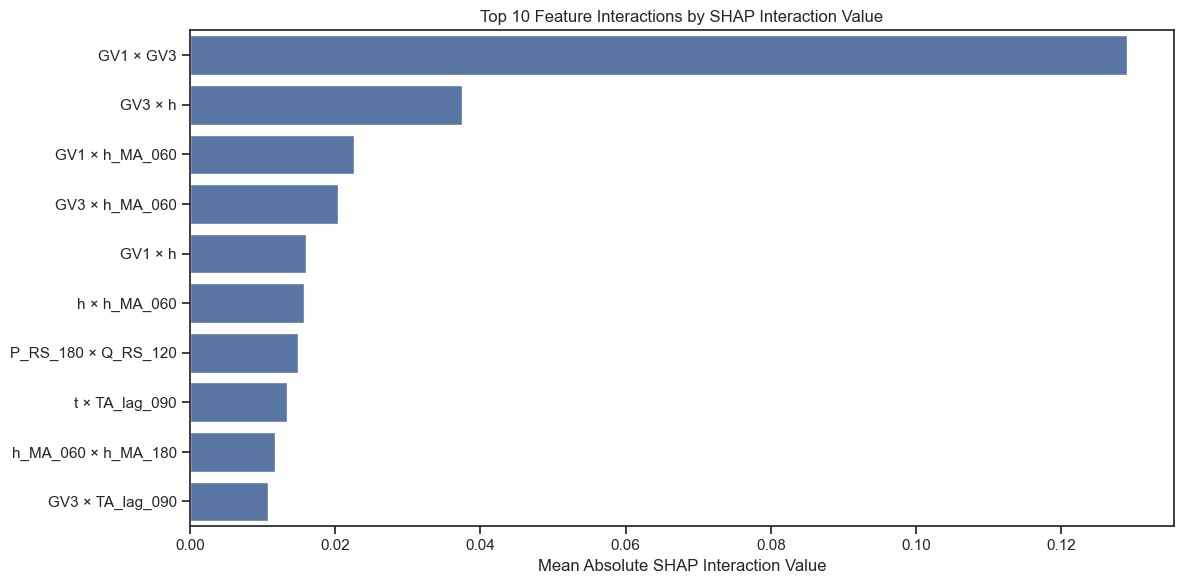

In [123]:
# Calculate SHAP interaction values
interaction_values = shap.TreeExplainer(LGBM_model).shap_interaction_values(X_test)

# Visualize the most important interactions
feature_names = X_test.columns
interaction_indices = np.triu_indices(interaction_values.shape[1], k=1)
mean_abs_interactions = np.abs(interaction_values[:, interaction_indices[0], interaction_indices[1]]).mean(0)
sorted_idx = np.argsort(-mean_abs_interactions)

# Get top 10 interactions
top_interactions = [(feature_names[interaction_indices[0][i]], 
                     feature_names[interaction_indices[1][i]], 
                     mean_abs_interactions[i])
                   for i in sorted_idx[:10]]

# Plot as a bar chart
plt.figure(figsize=(12, 6))
interaction_names = [f"{i[0]} × {i[1]}" for i in top_interactions]
interaction_values = [i[2] for i in top_interactions]
sns.barplot(x=interaction_values, y=interaction_names)
plt.title('Top 10 Feature Interactions by SHAP Interaction Value')
plt.xlabel('Mean Absolute SHAP Interaction Value')
plt.tight_layout()
plt.show()

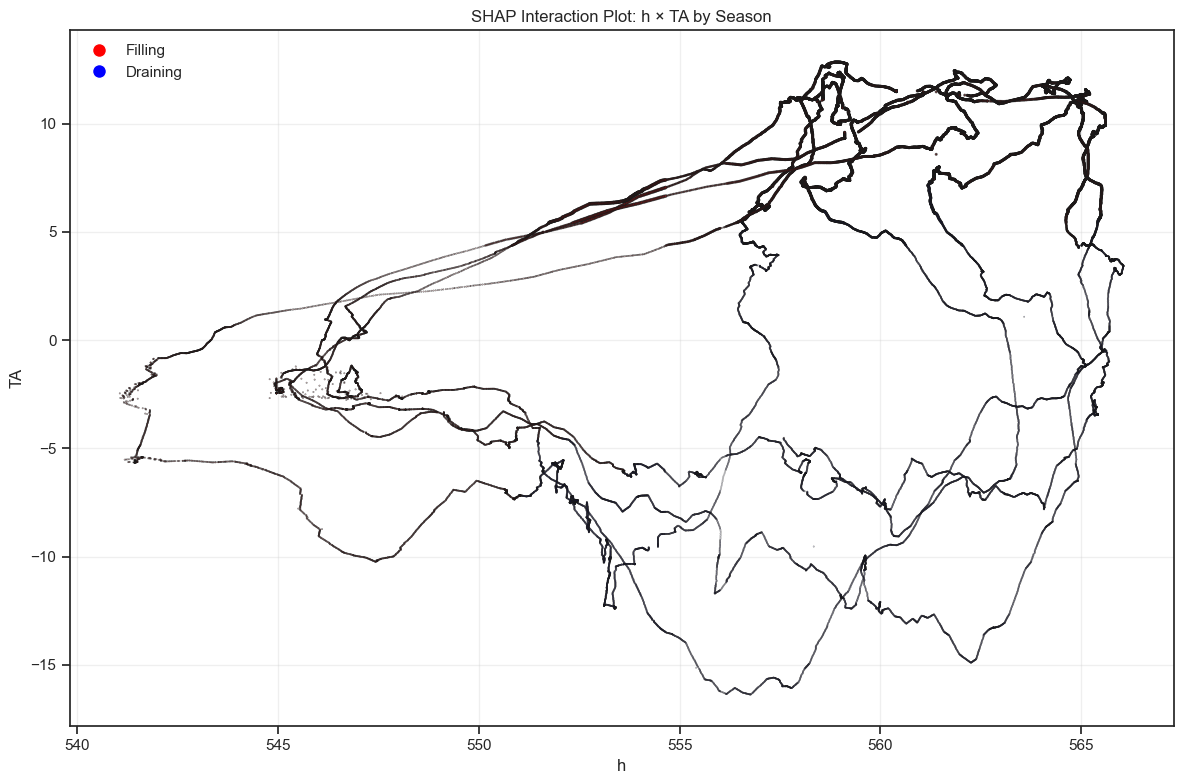

In [125]:
# First, make sure we have the shap interaction values
explainer = shap.TreeExplainer(LGBM_model)
shap_interaction_values = explainer.shap_interaction_values(X)

# Create your filling/draining cohort labels
cohort_labels = np.array([
    'Filling' if (month >= 3 and month <= 9) else 'Draining' 
    for month in X_all['month']
])

# Choose the feature pair you want to examine
feature1 = "h"  # Replace with your actual feature name
feature2 = "TA"  # Replace with your actual feature name

# Create the dependence plot with colors based on your cohorts
plt.figure(figsize=(12, 8))

# Create a colormap for your cohorts
colors = np.array(['blue' if label == 'Draining' else 'red' for label in cohort_labels])

# Get indices of the features
feature_idx1 = list(X_all.columns).index(feature1)
feature_idx2 = list(X_all.columns).index(feature2)

# Extract the interaction values for this feature pair
interaction_values = shap_interaction_values[:, feature_idx1, feature_idx2]

# Create scatter plot
plt.scatter(
    X_all[feature1], 
    X_all[feature2],
    c=colors,  # Color by cohort
    s=100 * np.abs(interaction_values),  # Size by interaction strength
    alpha=0.7,
    edgecolor='k'
)

# Add a colorbar legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Filling', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Draining', markerfacecolor='blue', markersize=10)
]
plt.legend(handles=legend_elements)

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f"SHAP Interaction Plot: {feature1} × {feature2} by Season")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

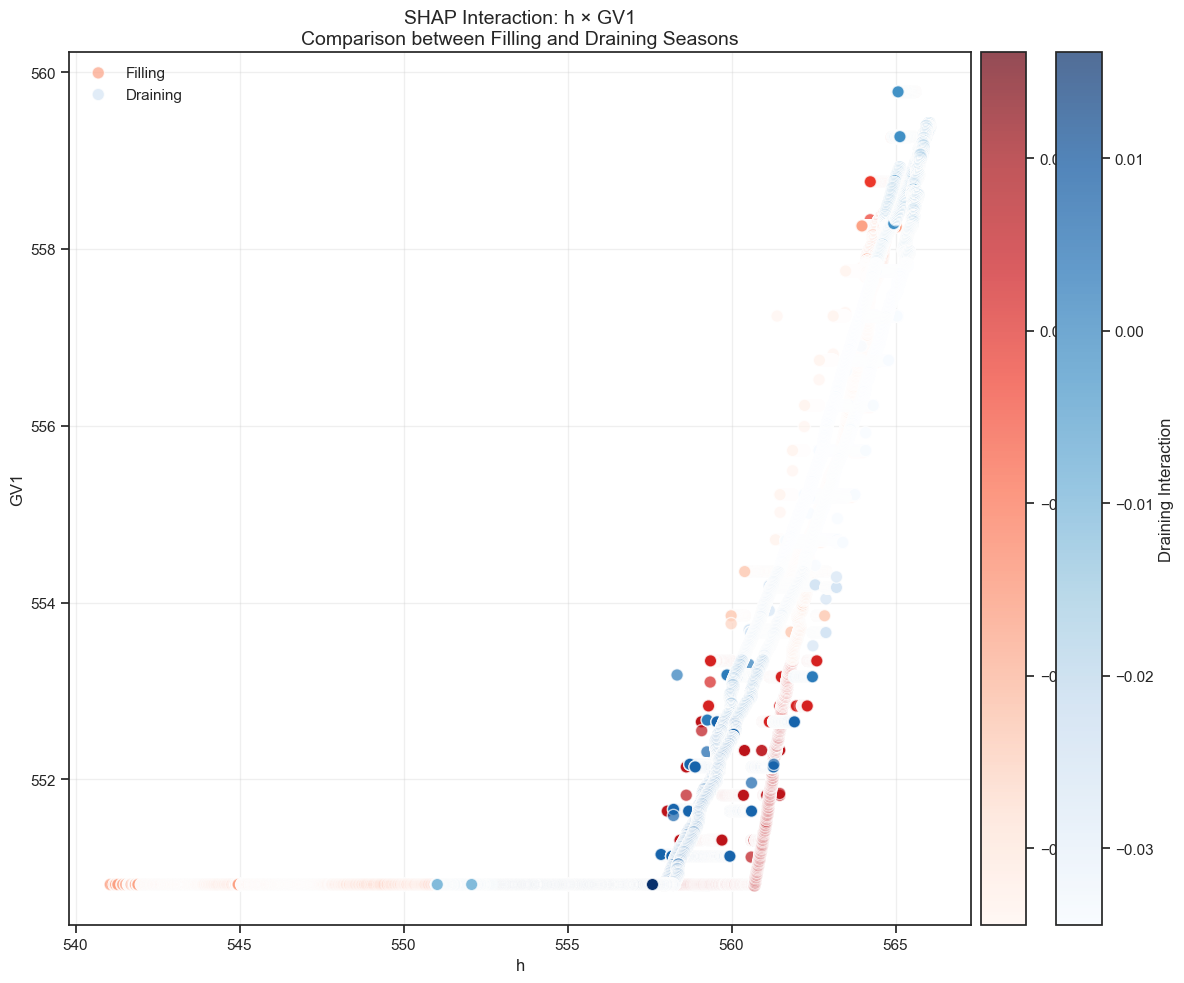

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose your feature pair
feature1 = "h"  # Replace with your actual feature
feature2 = ""  # Replace with your actual feature

# Get feature indices
idx1 = list(X_all.columns).index(feature1)
idx2 = list(X_all.columns).index(feature2)

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Filter data by cohort
filling_mask = cohort_labels == 'Filling'
draining_mask = cohort_labels == 'Draining'

# Get interaction values
filling_interactions = shap_interaction_values[filling_mask, idx1, idx2]
draining_interactions = shap_interaction_values[draining_mask, idx1, idx2]

# Plot Filling cohort
scatter1 = ax.scatter(
    X_all.loc[filling_mask, feature1],
    X_all.loc[filling_mask, feature2],
    c=filling_interactions,
    cmap='Reds',
    alpha=0.7,
    s=80,
    edgecolor='white',
    label='Filling'
)

# Plot Draining cohort
scatter2 = ax.scatter(
    X_all.loc[draining_mask, feature1],
    X_all.loc[draining_mask, feature2],
    c=draining_interactions,
    cmap='Blues',
    alpha=0.7,
    s=80,
    edgecolor='white',
    label='Draining'
)

# Add colorbars
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="5%", pad=0.1)
cax2 = divider.append_axes("right", size="5%", pad=0.3)
plt.colorbar(scatter1, cax=cax1, label='Filling Interaction')
plt.colorbar(scatter2, cax=cax2, label='Draining Interaction')

# Add labels and title
ax.set_xlabel(feature1, fontsize=12)
ax.set_ylabel(feature2, fontsize=12)
ax.set_title(f"SHAP Interaction: {feature1} × {feature2}\nComparison between Filling and Draining Seasons", fontsize=14)

# Add legend
ax.legend()

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()